# PLACEHOLDER FOR TITLE

## PLACEHOLDER FOR DESCRIPTION

### PACKAGES AND LIBRARIES

In [1]:
# Here is all the libs needed to do the analysis and plotting for "TITLE AND THONG"
# python packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pymc as pm
import arviz as az
import xarray as xr

In [2]:
# R packages
import rpy2

%load_ext rpy2.ipython

In [3]:
%%R
library(tidyverse) 
library(zoo)
library(ggtree)
library(ape)
library(ggimage)
library(ggpubr)
library(ggridges)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


R[write to console]: 
Attaching package: ‘zoo’


R[write to console]: The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric


R[write to console]: ggtree v3.10.0 For help: https://yulab-smu.top/treedata-book/

If you use the ggtree package suite in published research, please cite
the appropriate paper(s):

Guangchuang Yu, David Smith, Huachen Zhu, Yi Guan, Tommy Tsan-Yuk Lam.
ggtree: an R package for visualization and annotation of phylogenetic
trees with their covariates and other associated data. Methods in
Ecology and Evolution. 2017, 8(1):28-36. doi:10.1111/2041-210X.12628

G Yu. Data Integration, Manipulation and Visualization of Phylogenetic
Trees (1st ed.). Chapman and Hall/CRC. 2022. ISBN: 9781032233574

Guangchuang Yu, Tommy Tsan-Yuk Lam, Huachen Zhu, Yi Guan. Two methods
for mapping and visualizing associated data on phylogeny using ggtree.
Molecular Biology and Evolution. 2018, 35(12):3041-3043.
doi:10.1093/molbev/msy194

R[write to console]: 
A

In [4]:
%%R

posterior_predictive <- function(x, slope_samples, intercept_samples) {
  slope_samples * x + intercept_samples
}

# Calculate the credibility interval
credibility_interval <- function(x, slope_samples, intercept_samples, prob = c(0.025, 0.975)) {
  quantile(posterior_predictive(x, slope_samples, intercept_samples), prob)
}

# Merging with phylogenetic grouping, removing chrX, Low callability regions and NaNs

In [5]:
# load raw dataframes (Only for the first time, downstream use the saved dataframes)
df = pd.read_csv('../data/stats/all_species.combined.stats.csv', sep = ',')
pg_names = pd.read_csv('../data/genus_phylogenetic_group_metadata.txt', sep = '\t')
# get phylogenetic group names
df['genus'] = df['species'].str.split('_').str[0]
df['phylogenetic_group'] = df['genus'].map(pg_names.set_index('genus')['pg_name'])
# Filter regions away that are freq_median < 0.5 or chrX and remove NANs
df = df[df['chrom'] != 'chrX']
df = df[df['freq_median'] > 0.5]
df = df[df['n_variants'] != 0]
# Drop NaN values in recombination rate
df = df.dropna(subset=['cm_start', 'cm_end', 'cm_per_mb'])

# Save the filtered dataframe
df.to_csv('../results/stats/all_species.combined.stats.filtered.csv', index=False)

#### Pi in Highest 5% recombining regions 

In [25]:
%%R
df <- read_delim('../results/stats/all_species.combined.stats.filtered.csv', delim=',') %>%
            group_by(species) %>%
            mutate(rec_bin = ntile(cm_per_mb, 20)) %>%
            group_by(species,rec_bin) %>%
            reframe(
                highest_pi = median(diversity, na.rm=TRUE),
            ) %>%
            filter(rec_bin==20)
write.csv(df,'../results/stats/diversity_in_highest_recombination_bin.csv')

Rows: 3818191 Columns: 21
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (4): chrom, species, genus, phylogenetic_group
dbl (17): start, end, n_variants, diversity, n_singletons, singleton_proport...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


# Tajimas D data

In [ ]:
# # Remove species with less than 5 valid samples
# tajimas_d = pd.read_csv('../results/stats/all_species.combined.stats.filtered.csv', sep = ',')
# valid_species_count = pd.read_csv('../data/valid_species_counts.csv', sep = ',')
# # Merge with valid_species_count and filter species with less than 5 valid samples
# tajimas_d = tajimas_d.merge(valid_species_count, on='species')
# tajimas_d = tajimas_d[tajimas_d['valid_samples'] >= 5]
# tajimas_d.to_csv('../results/stats/tajimas_d.filtered.csv', index=False)

In [11]:
%%R
df <- read_delim('../results/stats/tajimas_d.filtered.csv') %>% group_by(species) %>% mutate(rec_bin = ntile(cm_per_mb, 20))

Rows: 549212 Columns: 22
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (4): chrom, species, genus, phylogenetic_group
dbl (18): start, end, n_variants, diversity, n_singletons, singleton_proport...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [12]:
%%R
# Calculate mean values per species and rec_bin for visualization
df_summary <- df %>% 
    group_by(species, phylogenetic_group, rec_bin) %>%
    summarise(
        median_tajimas_d = median(tajima_d, na.rm = TRUE),
        median_singleton_proportion = median(singleton_proportion, na.rm= TRUE),
        median_diversity = median(diversity, na.rm = TRUE),
        median_rec_rate = median(cm_per_mb),
        .groups = 'drop'
    )

df_summary %>% filter(species == 'Alouatta_macconnelli')

# A tibble: 20 × 7
   species    phylogenetic_group rec_bin median_tajimas_d median_singleton_pro…¹
   <chr>      <chr>                <int>            <dbl>                  <dbl>
 1 Alouatta_… New_world_monkeys        1        -0.186                     0.427
 2 Alouatta_… New_world_monkeys        2        -0.0836                    0.411
 3 Alouatta_… New_world_monkeys        3        -0.0473                    0.401
 4 Alouatta_… New_world_monkeys        4        -0.0353                    0.398
 5 Alouatta_… New_world_monkeys        5        -0.0236                    0.403
 6 Alouatta_… New_world_monkeys        6         0.0216                    0.384
 7 Alouatta_… New_world_monkeys        7        -0.0203                    0.395
 8 Alouatta_… New_world_monkeys        8        -0.0233                    0.392
 9 Alouatta_… New_world_monkeys        9         0.00612                   0.389
10 Alouatta_… New_world_monkeys       10        -0.0183                    0.392
11 Alouat

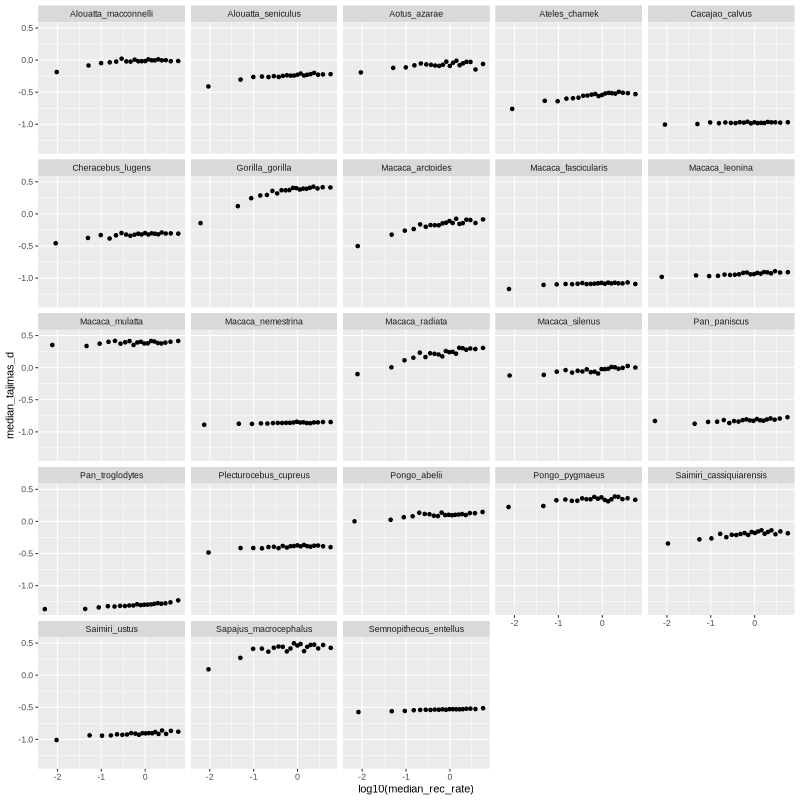

In [13]:
%%R -w 800 -h 800
df_summary %>%
    ggplot(aes(x = log10(median_rec_rate), y = median_tajimas_d)) +
    geom_point() +
    facet_wrap(~species) 

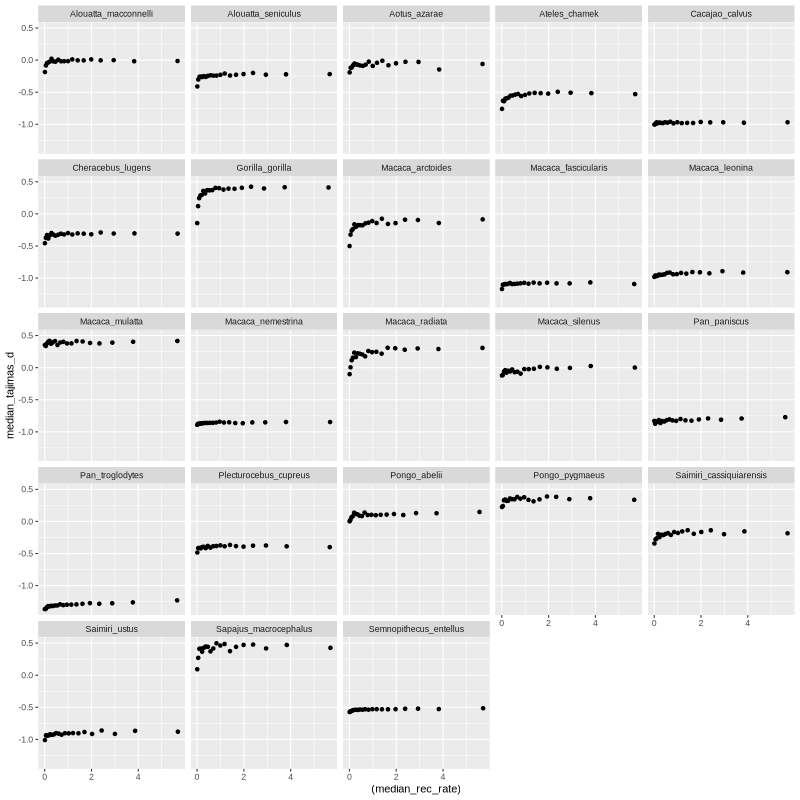

In [14]:
%%R -w 800 -h 800
df_summary %>%
    ggplot(aes(x = (median_rec_rate), y = median_tajimas_d)) +
    geom_point() +
    facet_wrap(~species) 

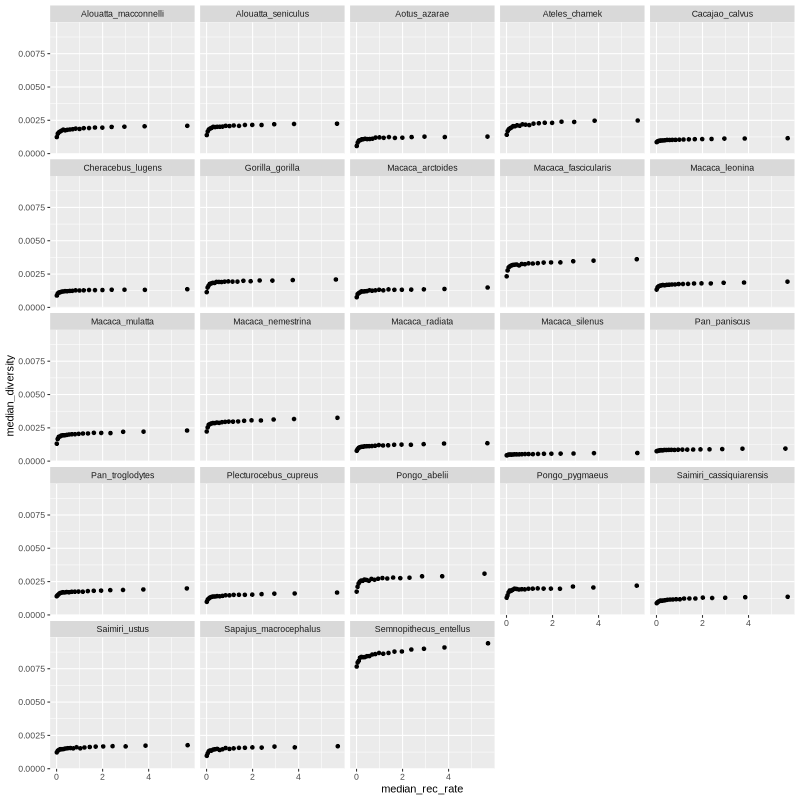

In [15]:
%%R -w 800 -h 800
df_summary %>%
    ggplot(aes(x = median_rec_rate, y = median_diversity)) +
    geom_point() +
    facet_wrap(~species) 

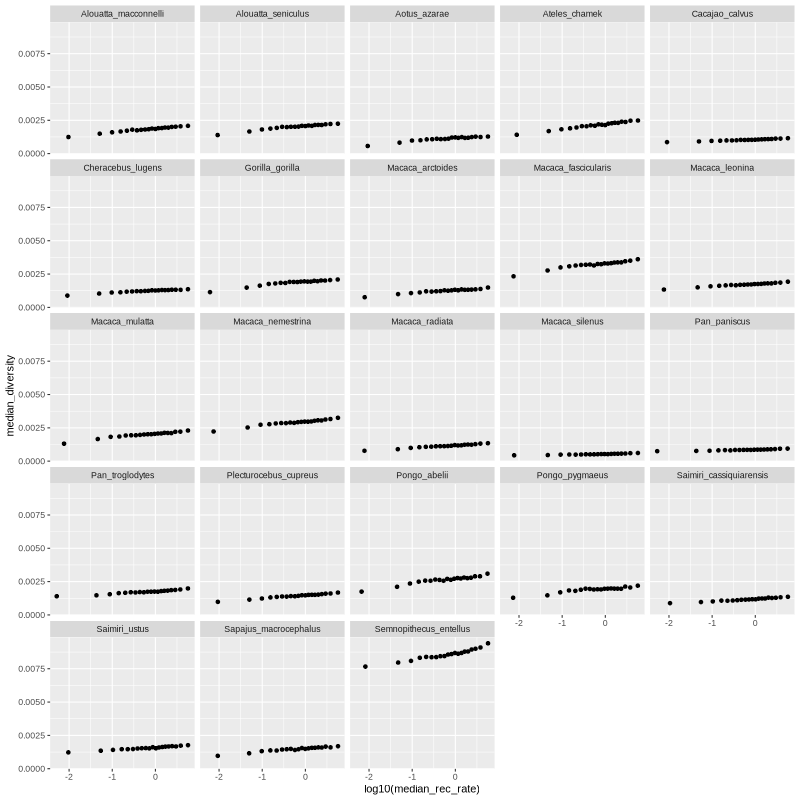

In [16]:
%%R -w 800 -h 800
df_summary %>%
    ggplot(aes(x = log10(median_rec_rate), y = median_diversity)) +
    geom_point() +
    facet_wrap(~species) 

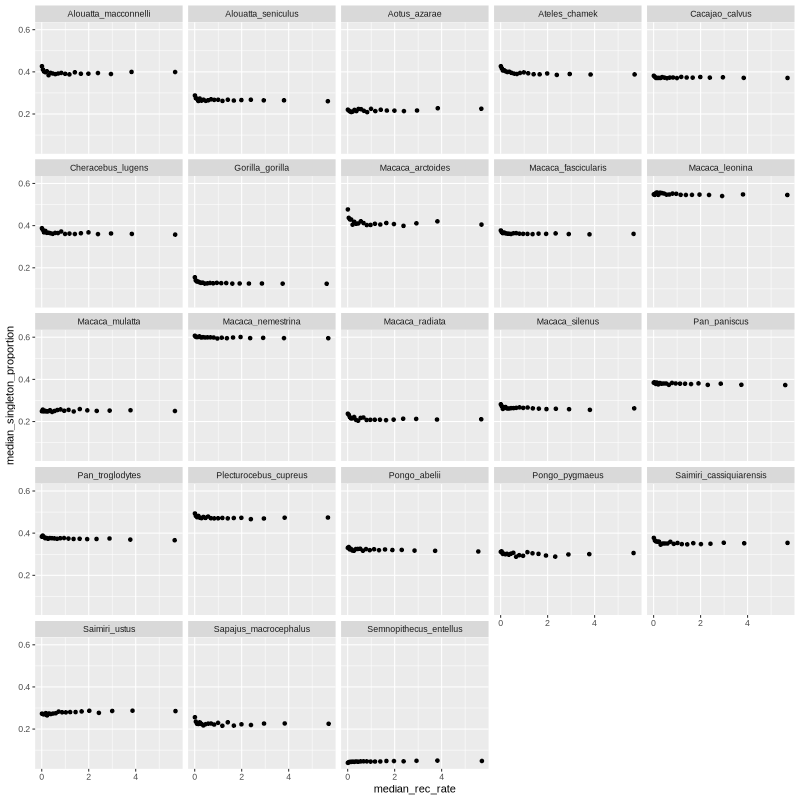

In [18]:
%%R -w 800 -h 800
df_summary %>%
    ggplot(aes(x = median_rec_rate, y = median_singleton_proportion)) +
    geom_point() +
    facet_wrap(~species) 

# Tajimas D Model and Figure

In [5]:
dataframe = pd.read_csv('../results/stats/tajimas_d.filtered.csv')
Ne = pd.read_csv('../results/Ne_modelling/predicted_Ne.csv')
dataframe = dataframe.dropna()

In [6]:
Ne.columns

Index(['species', 'median_predicted_rate', 'Ne_median', 'Ne_upper',
       'Ne_lower'],
      dtype='object')

In [7]:
dataframe = dataframe.merge(Ne, left_on='species', right_on='species')
dataframe = dataframe[dataframe['cm_per_mb'] != 0]

In [8]:
dataframe

,chrom,start,end,n_variants,diversity,n_singletons,singleton_proportion,tajima_d,bases,cm_start,...,window_size_mean,sum_n_mean,species,genus,phylogenetic_group,valid_samples,median_predicted_rate,Ne_median,Ne_upper,Ne_lower
0,chr1,1600001,1700000,265.0,0.000543,155.0,0.584906,-1.398232,100000.0,0.166468,...,99999.0,50647.125000,Cheracebus_lugens,Cheracebus,New_world_monkeys,8,7.769189e-09,43851.101463,51099.766771,37691.201743
1,chr1,1800001,1900000,200.0,0.000439,89.0,0.445000,-1.180108,100000.0,0.212782,...,99999.0,61995.750000,Cheracebus_lugens,Cheracebus,New_world_monkeys,8,7.769189e-09,43851.101463,51099.766771,37691.201743
2,chr1,1900001,2000000,332.0,0.000877,108.0,0.325301,-0.539073,100000.0,0.216024,...,99999.0,55266.250000,Cheracebus_lugens,Cheracebus,New_world_monkeys,8,7.769189e-09,43851.101463,51099.766771,37691.201743
3,chr1,2000001,2100000,292.0,0.000708,131.0,0.448630,-0.855039,100000.0,0.389473,...,99999.0,53921.125000,Cheracebus_lugens,Cheracebus,New_world_monkeys,8,7.769189e-09,43851.101463,51099.766771,37691.201743
4,chr1,2200001,2300000,267.0,0.000631,119.0,0.445693,-0.939903,100000.0,0.537176,...,99999.0,69178.500000,Cheracebus_lugens,Cheracebus,New_world_monkeys,8,7.769189e-09,43851.101463,51099.766771,37691.201743
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
548208,chr9,134800001,134900000,510.0,0.001070,226.0,0.443137,-0.964267,100000.0,149.033934,...,99999.0,49476.000000,Pan_paniscus,Pan,Great_apes,11,1.071039e-08,22035.798423,25789.453144,19372.684874
548209,chr9,134900001,135000000,380.0,0.000736,180.0,0.473684,-1.206037,100000.0,149.805181,...,99999.0,57539.692308,Pan_paniscus,Pan,Great_apes,11,1.071039e-08,22035.798423,25789.453144,19372.684874
548210,chr9,135000001,135100000,477.0,0.001095,180.0,0.377358,-0.668335,100000.0,150.030461,...,99999.0,57009.307692,Pan_paniscus,Pan,Great_apes,11,1.071039e-08,22035.798423,25789.453144,19372.684874
548211,chr9,135400001,135500000,524.0,0.001161,176.0,0.335878,-0.790234,100000.0,151.911788,...,99999.0,55502.769231,Pan_paniscus,Pan,Great_apes,11,1.071039e-08,22035.798423,25789.453144,19372.684874


In [9]:
dataframe['z_Ne_median'] = dataframe['Ne_median'].transform(lambda x: (x - x.mean()) / x.std())
dataframe['log10_cm_per_mb'] = np.log10(dataframe['cm_per_mb'])
dataframe['z_log10_cm_per_mb'] = dataframe.groupby('species')['log10_cm_per_mb'].transform(lambda x: (x - x.mean()) / x.std())
dataframe['z_tajimasD'] = dataframe.groupby('species')['tajima_d'].transform(lambda x: (x - x.mean()) / x.std())

In [10]:
### make data in a pymc3 format 
unique_Species_log = dataframe['species'].unique()
species_lookup_log = dict(zip(unique_Species_log, range(len(unique_Species_log))))
Ne_log = (pd.DataFrame([dataframe['species'], dataframe['z_Ne_median']]).transpose()).drop_duplicates()
tajimas_d_values = dataframe['z_tajimasD'].values
recombinationrate_log = dataframe['z_log10_cm_per_mb'].values
species_log = dataframe['species'].replace(species_lookup_log).values

# Convert Ne values to float array
ne_values = Ne_log['z_Ne_median'].astype(float).values

/tmp/ipykernel_3243714/2601377457.py:7: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  species_log = dataframe['species'].replace(species_lookup_log).values


In [29]:
### Step 4: Define model
model = pm.Model(coords={
    "Species": unique_Species_log,
    "obs_id": np.arange(len(recombinationrate_log))
})

with model:
    recomb = pm.Data('recomb', recombinationrate_log, dims='obs_id')
    tajimas_d = pm.Data('tajimas_d', tajimas_d_values, dims='obs_id')
    sp = pm.Data('sp', species_log, dims='obs_id')
    Ne = pm.Data('Ne', ne_values, dims='Species')
    
    # Priors
    g0 = pm.Normal("g0", mu=0, sigma=0.5)
    g1 = pm.Normal("g1", mu=0, sigma=1)
    h0 = pm.Normal("h0", mu=0, sigma=0.5)
    h1 = pm.Normal("h1", mu=0, sigma=1)
    
    mu_a = g0 + g1*Ne
    mu_b = h0 + h1*Ne
    sigma_a = pm.HalfNormal("sigma_a", 0.5)  # More constrained variation
    sigma_b = pm.HalfNormal("sigma_b", 0.5)
    
    a_offset = pm.Normal("a_offset", 0, sigma=1, dims="Species")
    a = pm.Deterministic("a", mu_a + a_offset * sigma_a, dims="Species")
    
    b_offset = pm.Normal("b_offset", 0, sigma=1, dims="Species")
    b = pm.Deterministic("b", mu_b + b_offset * sigma_b, dims="Species")
    
    y = a[sp] + b[sp] * recomb
    sigma = pm.HalfNormal("sigma", 1.0) 
    
    # Likelihood
    tajimas_d_obs = pm.Normal("tajimas_d_obs", mu=y, sigma=sigma, observed=tajimas_d, dims="obs_id")

In [30]:
#run model
with model:
    model_idata = pm.sample(1000, tune=500, target_accept=0.95, return_inferencedata=True,
                                                                progressbar=True, cores=4, chains=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [g0, g1, h0, h1, sigma_a, sigma_b, a_offset, b_offset, sigma]


Output()

Sampling 4 chains for 500 tune and 1_000 draw iterations (2_000 + 4_000 draws total) took 2086 seconds.


<Axes: >

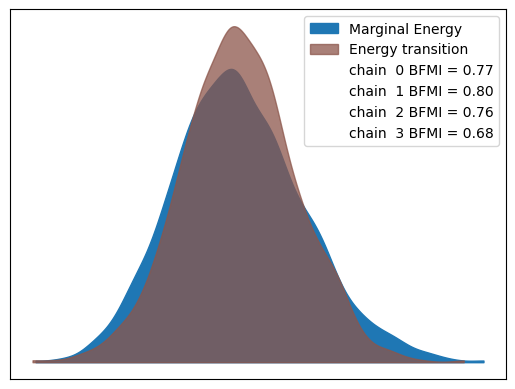

In [31]:
az.plot_energy(model_idata)

In [32]:
az.to_netcdf(model_idata, '../data/Ne_TajimasD_model.nc')
g0 = model_idata.posterior.g0.to_dataframe()
g0.to_csv("../results/tajimasD/g0_240325", sep=",")
g1 = model_idata.posterior.g1.to_dataframe()
g1.to_csv("../results/tajimasD/g1_240325", sep=",")
h0 = model_idata.posterior.h0.to_dataframe()
h0.to_csv("../results/tajimasD/h0_240325", sep=",")
h1 = model_idata.posterior.h1.to_dataframe()
h1.to_csv("../results/tajimasD/h1_240325", sep=",")
a =  model_idata.posterior.a.to_dataframe()
a.to_csv("../results/tajimasD/a_240325", sep=",")
b =  model_idata.posterior.b.to_dataframe()
b.to_csv("../results/tajimasD/b_240325", sep=",")

In [79]:
h1

h1
chain draw          
0     0     0.018058
      1     0.019987
      2     0.018456
      3     0.005319
      4     0.002644
...              ...
3     995   0.009828
      996   0.006682
      997   0.004058
      998   0.013257
      999   0.015439

[4000 rows x 1 columns]

(array([  1.,   1.,   0.,   0.,   1.,   1.,   0.,   3.,   2.,   6.,   5.,
          3.,   7.,   3.,   3.,   8.,   7.,  11.,  10.,   9.,   8.,  14.,
         20.,  16.,  18.,  22.,  33.,  32.,  29.,  26.,  42.,  30.,  47.,
         44.,  47.,  64.,  60.,  84.,  67.,  91.,  89.,  99., 113., 104.,
        102., 111., 128., 129., 105., 104., 117., 114., 100., 120., 124.,
         95., 112.,  86., 100.,  92., 107.,  96.,  79.,  64.,  75.,  60.,
         48.,  53.,  42.,  41.,  45.,  26.,  26.,  23.,  24.,  23.,  19.,
         16.,   8.,   8.,  15.,  11.,   7.,  14.,   4.,   7.,   6.,   4.,
          7.,   2.,   4.,   2.,   2.,   4.,   2.,   1.,   2.,   1.,   0.,
          3.]),
 array([-2.15806086e-02, -2.09650938e-02, -2.03495791e-02, -1.97340644e-02,
        -1.91185497e-02, -1.85030350e-02, -1.78875203e-02, -1.72720055e-02,
        -1.66564908e-02, -1.60409761e-02, -1.54254614e-02, -1.48099467e-02,
        -1.41944319e-02, -1.35789172e-02, -1.29634025e-02, -1.23478878e-02,
        -1.173

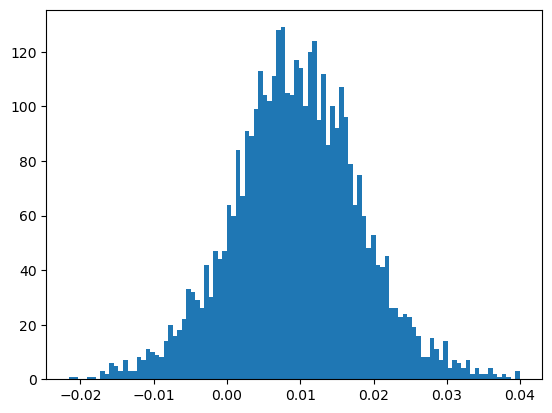

In [81]:
plt.hist(h1, bins=100)

In [82]:
samples = h1.values.flatten()
threshold = 0
prob = np.mean(samples > threshold)
print(f"Probability of exceeding {threshold}: {prob:.4f}")

Probability of exceeding 0: 0.8710


In [83]:
h1.quantile(0.025)

h1   -0.008067
Name: 0.025, dtype: float64

In [84]:
h1.quantile(0.975)

h1    0.02735
Name: 0.975, dtype: float64

## Tajimas D figure

In [63]:
%%R
# save data in a nicer format 
# df = read_delim('../results/tajimasD/b_240325', delim = ',')
# pg_names = read_delim('../data/genus_phylogenetic_group_metadata.txt', delim = '\t')
# b_species <- df %>% 
#     group_by(Species) %>% reframe(
#     upper = quantile(b,.95),
#     lower = quantile(b,.05),
#     b = mean(b))
# b_species <- b_species %>% mutate(species_full = Species) %>% separate(Species, c('genus','ssp'))
# fig4data = inner_join(b_species, pg_names, by = c("genus" = "genus"))
# write_csv(fig4data,'../results/tajimasD/tajimasD_slope.csv')


Rows: 92000 Columns: 4
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (1): Species
dbl (3): chain, draw, b

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 57 Columns: 2
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (2): genus, pg_name

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [64]:
%%R
# Read the data from single file
fig4_data <- read_delim('../results/tajimasD/tajimasD_slope.csv', delim=',')
fig4data$pg_name <- factor(fig4data$pg_name, levels=c("New_world_monkeys", "Old_world_monkeys", "Great_apes", "Prosimians"))
fig4data <- fig4data %>% arrange(pg_name)
fig4data <- fig4data %>% arrange(pg_name, desc(b))
print(n=24,fig4data)

Rows: 23 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): genus, ssp, species_full, pg_name
dbl (3): upper, lower, b



ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
# A tibble: 23 × 7
   genus         ssp              upper   lower      b species_full      pg_name
   <chr>         <chr>            <dbl>   <dbl>  <dbl> <chr>             <fct>  
 1 Ateles        chamek          0.111  0.0891  0.0997 Ateles_chamek     New_wo…
 2 Alouatta      seniculus       0.0856 0.0634  0.0746 Alouatta_senicul… New_wo…
 3 Alouatta      macconnelli     0.0850 0.0640  0.0746 Alouatta_macconn… New_wo…
 4 Saimiri       cassiquiarensis 0.0825 0.0602  0.0715 Saimiri_cassiqui… New_wo…
 5 Sapajus       macrocephalus   0.0750 0.0541  0.0645 Sapajus_macrocep… New_wo…
 6 Cheracebus    lugens          0.0696 0.0487  0.0594 Cheracebus_lugens New_wo…
 7 Plecturocebus cupreus         0.0492 0.0278  0.0386 Plecturocebus_cu… New_wo…
 8 Saimiri       ustus           0.0499 0.0260  0.0380 Saimiri_ustus     New_wo…
 9 Aotus        

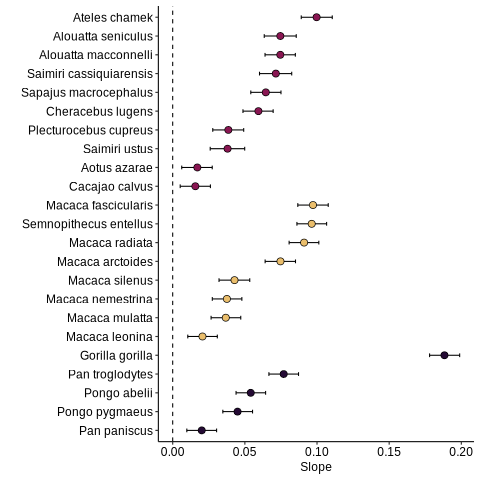

In [65]:
%%R
plot_4 <- fig4data %>%
  ggplot(aes(y=gsub("_", " ", species_full), x=b)) +
  geom_errorbarh(aes(xmin=lower, xmax=upper), height=.2) +
  geom_vline(xintercept=0, linetype="dashed", color="black") +
  geom_point(aes(fill=pg_name), size=3, shape=21, color="black") +
  scale_fill_manual(values=c(
    "Great_apes"="#240a34",
    "New_world_monkeys"="#891652",
    "Old_world_monkeys"="#eabe6c",
    "Prosimians"="#db7552")) +
  scale_y_discrete(limits=gsub("_", " ", rev(fig4data$species_full))) +
  ggpubr::theme_pubr(legend="none") +
  xlab("Slope") +
  ylab("")

print(plot_4)

In [66]:
%%R
ggsave("../figures/figure4/figure4.png", plot_4, width = 10, height = 8, dpi = 600)

# Ne Modelling 

In [4]:
# Building the model
df = pd.read_csv('../data/Bergeron_et_al_2023_generationtimes_and_mutationrate.csv', sep=';',decimal=',')
df['m_generation']=df['Mutation rate per site per generation (m_generation)']
df['m_generation'] = pd.to_numeric(df['m_generation'])
df['Avg_age'] = pd.to_numeric(df['Avg_age'])
species_list=['Pan_troglodytes','Hylobates_lar','Homo_sapiens','Pithecia_pithecia','Mandrillus_leucophaeus','Saimiri_boliviensis_boliviensis']
primates = df[df['Species_name'].isin(species_list)]

In [7]:
basic_model = pm.Model()

with basic_model:
    alpha = pm.Normal('alpha',mu = 0, sigma = 0.1)
    beta = pm.Normal('beta',mu = 0, sigma = 0.1)
    sigma = pm.Exponential('sigma', lam=0.001)
    #expected outcome
    mu = alpha + beta * (primates['Avg_age'])
    # likelihood (sampling distribution) of observations 
    obs = pm.Normal('obs', mu=mu, sigma=sigma, observed=primates['m_generation'])

In [8]:
log_scaled_g = pm.Model()

with log_scaled_g:
    alpha = pm.Normal('alpha',mu = 0, sigma = 0.1)
    beta = pm.Normal('beta',mu = 0, sigma = 0.1)
    sigma = pm.Exponential('sigma', lam=0.001)
    x = pm.MutableData("x", primates['Avg_age'])
    #expected outcome
    mu = alpha + beta * np.log10(x)
    # likelihood (sampling distribution) of observations 
    obs = pm.Normal('obs', mu=mu, sigma=sigma, observed=primates['m_generation'])

/home/bjarkemp/miniforge3/envs/bircproject/lib/python3.12/site-packages/pymc/data.py:303: FutureWarning: MutableData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(


In [9]:
halfnormal = pm.Model()

with halfnormal:
    alpha = pm.HalfNormal('alpha',sigma = 0.1)
    beta = pm.Normal('beta',mu = 0, sigma = 0.1)
    sigma = pm.Exponential('sigma', lam=0.001)
    x = pm.MutableData("x", primates['Avg_age'])
    #expected outcome
    mu = alpha + beta * np.log10(x)
    # likelihood (sampling distribution) of observations 
    obs = pm.Normal('obs', mu=mu, sigma=sigma, observed=primates['m_generation'])

/home/bjarkemp/miniforge3/envs/bircproject/lib/python3.12/site-packages/pymc/data.py:303: FutureWarning: MutableData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(


In [13]:
with basic_model:
    basic_model_trace = pm.sample(1000, tune=500, target_accept=0.99, return_inferencedata=True,
                            progressbar=True, cores=4, chains=4)

with log_scaled_g:
    log_scaled_g_trace = pm.sample(1000, tune=500, target_accept=0.99, return_inferencedata=True,
                            progressbar=True, cores=4, chains=4)

with halfnormal:
    halfnormal_trace = pm.sample(1000, tune=500, target_accept=0.99, return_inferencedata=True,
                            progressbar=True, cores=4, chains=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, sigma]


Output()

Sampling 4 chains for 500 tune and 1_000 draw iterations (2_000 + 4_000 draws total) took 54 seconds.
There were 817 divergences after tuning. Increase `target_accept` or reparameterize.
Chain 1 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 2 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, sigma]


Output()

Sampling 4 chains for 500 tune and 1_000 draw iterations (2_000 + 4_000 draws total) took 57 seconds.
Chain 0 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 1 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 2 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 3 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 job

Output()

Sampling 4 chains for 500 tune and 1_000 draw iterations (2_000 + 4_000 draws total) took 100 seconds.
Chain 0 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 1 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 2 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 3 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [35]:
# # Extract posterior samples for each model
# basic_posterior = basic_model_trace.posterior
# log_scaled_posterior = log_scaled_g_trace.posterior
# halfnormal_posterior = halfnormal_trace.posterior

# # Create dataframes for each model's parameters
# basic_params = pd.DataFrame({
#     'alpha': basic_posterior.alpha.values.flatten(),
#     'beta': basic_posterior.beta.values.flatten()
# })

# log_scaled_params = pd.DataFrame({
#     'alpha': log_scaled_posterior.alpha.values.flatten(),
#     'beta': log_scaled_posterior.beta.values.flatten()
# })

# halfnormal_params = pd.DataFrame({
#     'alpha': halfnormal_posterior.alpha.values.flatten(),
#     'beta': halfnormal_posterior.beta.values.flatten()
# })

# # Save to CSV files
# basic_params.to_csv('../results/Ne_modelling/basic_model_parameters.csv', index=False)
# log_scaled_params.to_csv('../results/Ne_modelling/log_scaled_parameters.csv', index=False)
# halfnormal_params.to_csv('../results/Ne_modelling/halfnormal_parameters.csv', index=False)

In [14]:
with halfnormal:
    pm.compute_log_likelihood(halfnormal_trace)
with basic_model:
    pm.compute_log_likelihood(basic_model_trace)
with log_scaled_g:
    pm.compute_log_likelihood(log_scaled_g_trace)

df_comp_loo = az.compare({"basic_model": basic_model_trace, "log_scaled_g": log_scaled_g_trace, 'halfnormal':halfnormal_trace})
# df_comp_loo.to_csv('../results/Ne_modelling/comparison.csv')

Output()

Output()

Output()

In [24]:
# Predicting Ne 
generation_times = pd.read_csv('../data/Kuderna_et_al_2023.csv', usecols=['SPECIES_BINOMIAL', 'GENERATION_LENGTH'])
highest_pi = pd.read_csv('../results/stats/diversity_in_highest_recombination_bin.csv')
parameters_mu_model = pd.read_csv('../results/Ne_modelling/halfnormal_parameters.csv', sep = ',')
# Merge with highest_pi and rename column to match
generation_times = generation_times.merge(
    highest_pi,
    left_on='SPECIES_BINOMIAL',
    right_on='species',
    how='outer'
).drop('SPECIES_BINOMIAL', axis=1)

In [30]:
## Add missing generation time from COMBINE dataset
generation_times = generation_times.dropna(subset=['species'])
generation_times[generation_times['GENERATION_LENGTH'].isna()]
generation_times.loc[generation_times['species'] == 'Macaca_assamensis', 'GENERATION_LENGTH'] = 11.4 # value from COMBINE 

In [33]:
# Create function to predict mutation rate using the model parameters
def predict_mutation_rate(generation_time, alpha, beta):
    return alpha + beta * np.log10(generation_time)

# Initialize storage for results
results = []

# For each species
for _, row in generation_times.iterrows():
    species = row['species']
    gen_time = row['GENERATION_LENGTH']
    highest_pi = row['highest_pi']
    
    # Generate predictions using all posterior samples
    predictions = predict_mutation_rate(
        gen_time,
        parameters_mu_model['alpha'].values,
        parameters_mu_model['beta'].values
    )
    
    # Calculate median and HDI
    median_rate = np.median(predictions)
    hdi = az.hdi(predictions, hdi_prob=0.95)
    
    results.append({
        'species': species,
        'generation_time': gen_time,
        'highest_pi': highest_pi,
        'median_predicted_rate': median_rate,
        'hdi_lower': hdi[0],
        'hdi_upper': hdi[1]
    })

# Convert to dataframe
results_df = pd.DataFrame(results)

In [34]:
# Calculate Ne using the relationship Ne = pi/(4*mu)



results_df['Ne_median'] = results_df['highest_pi'] / (4 * results_df['median_predicted_rate'])

# Calculate Ne lower bound (using upper mutation rate bound)
results_df['Ne_lower'] = results_df['highest_pi'] / (4 * results_df['hdi_upper'])

# Calculate Ne upper bound (using lower mutation rate bound)
results_df['Ne_upper'] = results_df['highest_pi'] / (4 * results_df['hdi_lower'])

In [35]:
# Display species with highest Ne
print("Top 5 species by effective population size:")
print(results_df.nlargest(5, 'Ne_median')[['species', 'Ne_median']])

print("\nBottom 5 species by effective population size:")
print(results_df.nsmallest(5, 'Ne_median')[['species', 'Ne_median']])

Top 5 species by effective population size:
                    species      Ne_median
54     Chiropotes_albinasus  287675.404565
165  Semnopithecus_entellus  280763.665807
40     Cercopithecus_cephus  244083.817008
39   Cercopithecus_ascanius  197026.989128
115       Mandrillus_sphinx  174406.875750

Bottom 5 species by effective population size:
                          species    Ne_median
10              Alouatta_palliata  3904.873960
118                     Mico_spnv  5376.536661
153           Rhinopithecus_bieti  6603.924718
174  Trachypithecus_leucocephalus  6762.974675
92         Leontopithecus_rosalia  9627.231353


In [36]:
# Display species with highest Ne
print("Top 5 species by effective population size:")
print(results_df.nlargest(5, 'highest_pi')[['species', 'highest_pi']])

print("\nBottom 5 species by effective population size:")
print(results_df.nsmallest(5, 'highest_pi')[['species', 'highest_pi']])

Top 5 species by effective population size:
                    species  highest_pi
54     Chiropotes_albinasus    0.009640
165  Semnopithecus_entellus    0.009409
40     Cercopithecus_cephus    0.007585
39   Cercopithecus_ascanius    0.006992
115       Mandrillus_sphinx    0.005420

Bottom 5 species by effective population size:
                          species  highest_pi
10              Alouatta_palliata    0.000130
118                     Mico_spnv    0.000150
153           Rhinopithecus_bieti    0.000240
174  Trachypithecus_leucocephalus    0.000240
92         Leontopithecus_rosalia    0.000285


In [38]:
#selected_columns = ['species', 'median_predicted_rate', 'Ne_median', 'Ne_upper', 'Ne_lower']
#results_df[selected_columns].to_csv('../results/Ne_modelling/predicted_Ne.csv', index=False)

In [39]:
## Merge Ne to the actual data
#total = pd.read_csv('../results/stats/all_species.combined.stats.filtered.csv', sep = ',')
#ne_df = pd.read_csv('../results/Ne_modelling/predicted_Ne.csv')
#merged_df = total.merge(ne_df, on='species', how='left')
#merged_df.to_csv('../results/stats/all_species_ne.combined.stats.filtered.csv')

# Rolling Means 

In [156]:
%%R # create roll mean df
df <- read_delim('../results/stats/all_species_ne.combined.stats.filtered.csv', ',')
treedata <- readRDS("../data/phylogenetic_tree.rds")

In [135]:
%%R
calculate_rolling_diversity <- function(df, window_size = 5e6) {
  # Ensure data frame is properly sorted
  df <- df %>%
    arrange(species, chrom, start)
  
  # Function to calculate rolling median for each chromosome/species combination
  calculate_group_rolling_median <- function(group_df) {
    # Calculate rolling median with specified window size
    rolling_med <- rollmedian(group_df$diversity, 
                            k = ceiling(window_size / (group_df$start[2] - group_df$start[1])),
                            fill = NA,
                            align = "center")
    
    # Return data frame with results, including phylogenetic_group
    data.frame(
      position = group_df$start,
      rolling_diversity = rolling_med,
      phylogenetic_group = group_df$phylogenetic_group[1]  # Take first value since it's constant within group
    )
  }
  
  # Apply rolling window calculation to each chromosome/species group
  result <- df %>%
    group_by(species, chrom) %>%
    group_modify(~ calculate_group_rolling_median(.x)) %>%
    ungroup()
  
  return(result)
}

In [142]:
%%R
result <- calculate_rolling_diversity(df)
result$chrom <- factor(result$chrom, levels = c('chr1', 'chr2', 'chr3', 'chr4', 'chr5', 
                                      'chr6', 'chr7', 'chr8', 'chr9', 'chr10',
                                      'chr11', 'chr12', 'chr13', 'chr14', 'chr15',
                                      'chr16', 'chr17', 'chr18', 'chr19', 'chr20',
                                      'chr21', 'chr22'))

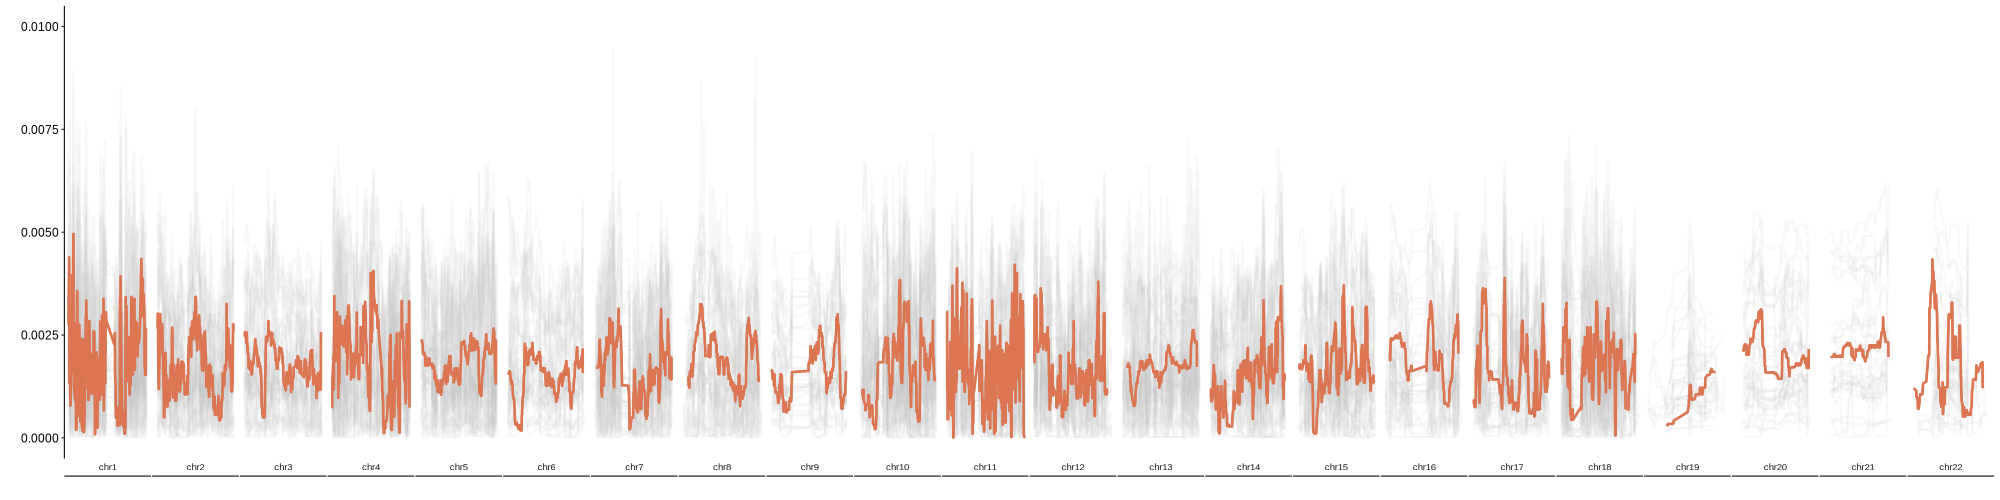

In [145]:
%%R -h 500 -w 2000
specific_species_prosimians <- result %>% 
    filter(phylogenetic_group == 'Prosimians') %>%
    filter(species == 'Lemur_catta') %>%
    group_by(species)

plot_diversity_genome_prosimians <- result %>% 
    filter(phylogenetic_group == 'Prosimians') %>%
    group_by(species) %>%
    ggplot(aes(x=position,y=rolling_diversity, group = species, col = species == 'Lemur_catta')) +
    geom_line(aes(alpha = ifelse(species == 'Lemur_catta', 1, 0.005)), size = 1) +
    geom_line(data = specific_species_prosimians,aes(x=position,y=rolling_diversity), size = 1.2) +
    ggpubr::theme_pubr(legend = 'none') +
    scale_colour_manual(values = c('grey','#db7552'))+
    facet_wrap(chrom~., scales = 'free_x', nrow=1, strip.position = 'bottom')+
    xlab('')+
    ylab('') +
    ylim(0,0.01)+
    theme(axis.text.x=element_blank(), #remove x axis labels
        axis.ticks.x=element_blank(),
        panel.spacing=unit(.08,"lines"),
        strip.background = element_blank())
    
plot_diversity_genome_prosimians

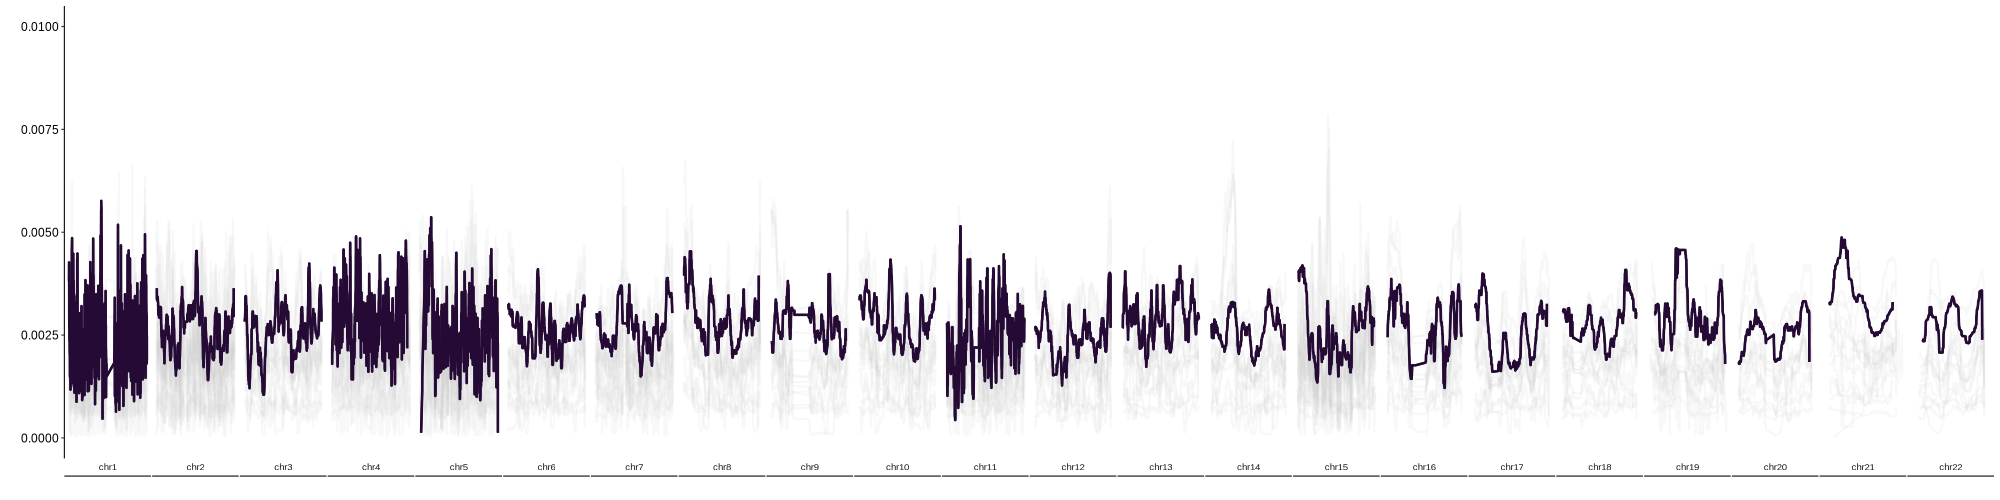

In [149]:
%%R -h 500 -w 2000
specific_species_apes <- result %>% 
    filter(phylogenetic_group == 'Great_apes') %>%
    filter(species == 'Pongo_abelii') %>%
    group_by(species)

plot_diversity_genome_apes <- result %>% 
    filter(phylogenetic_group == 'Great_apes') %>%
    group_by(species) %>%
    ggplot(aes(x=position,y=rolling_diversity, group = species, col = species == 'Pongo_abelii')) +
    geom_line(aes(alpha = ifelse(species == 'Pongo_abelii', 1, 0.005)), size = 1) +
    geom_line(data = specific_species_apes,aes(x=position,y=rolling_diversity), size = 1.2) +
    ggpubr::theme_pubr(legend = 'none') +
    scale_colour_manual(values = c('grey','#240a34'))+
    facet_wrap(chrom~., scales = 'free_x', nrow=1, strip.position = 'bottom')+
    xlab('')+
    ylab('') +
    ylim(0,0.01)+
    theme(axis.text.x=element_blank(), #remove x axis labels
        axis.ticks.x=element_blank(),
        panel.spacing=unit(.08,"lines"),
        strip.background = element_blank())
    
plot_diversity_genome_apes

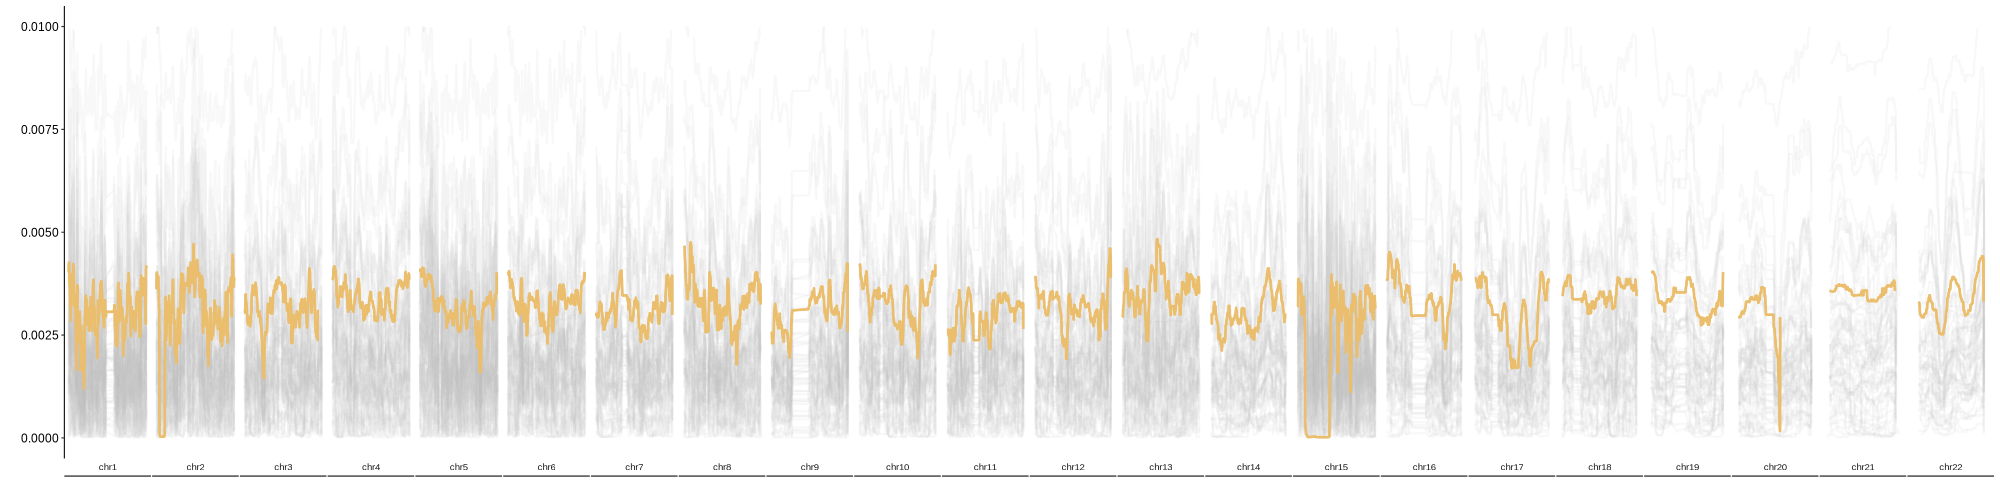

In [151]:
%%R -h 500 -w 2000
specific_species_old <- result %>% 
    filter(phylogenetic_group == 'Old_world_monkeys') %>%
    filter(species == 'Macaca_fascicularis') %>%
    group_by(species)

plot_diversity_genome_old <- result %>% 
    filter(phylogenetic_group == 'Old_world_monkeys') %>%
    group_by(species) %>%
    ggplot(aes(x=position,y=rolling_diversity, group = species, col = species == 'Macaca_fascicularis')) +
    geom_line(aes(alpha = ifelse(species == 'Macaca_fascicularis', 1, 0.005)), size = 1) +
    geom_line(data = specific_species_old,aes(x=position,y=rolling_diversity), size = 1.2) +
    ggpubr::theme_pubr(legend = 'none') +
    scale_colour_manual(values = c('grey','#eabe6c'))+
    facet_wrap(chrom~., scales = 'free_x', nrow=1, strip.position = 'bottom')+
    xlab('')+
    ylab('') +
    ylim(0,0.01)+
    theme(axis.text.x=element_blank(), #remove x axis labels
        axis.ticks.x=element_blank(),
        panel.spacing=unit(.08,"lines"),
        strip.background = element_blank())
    
plot_diversity_genome_old

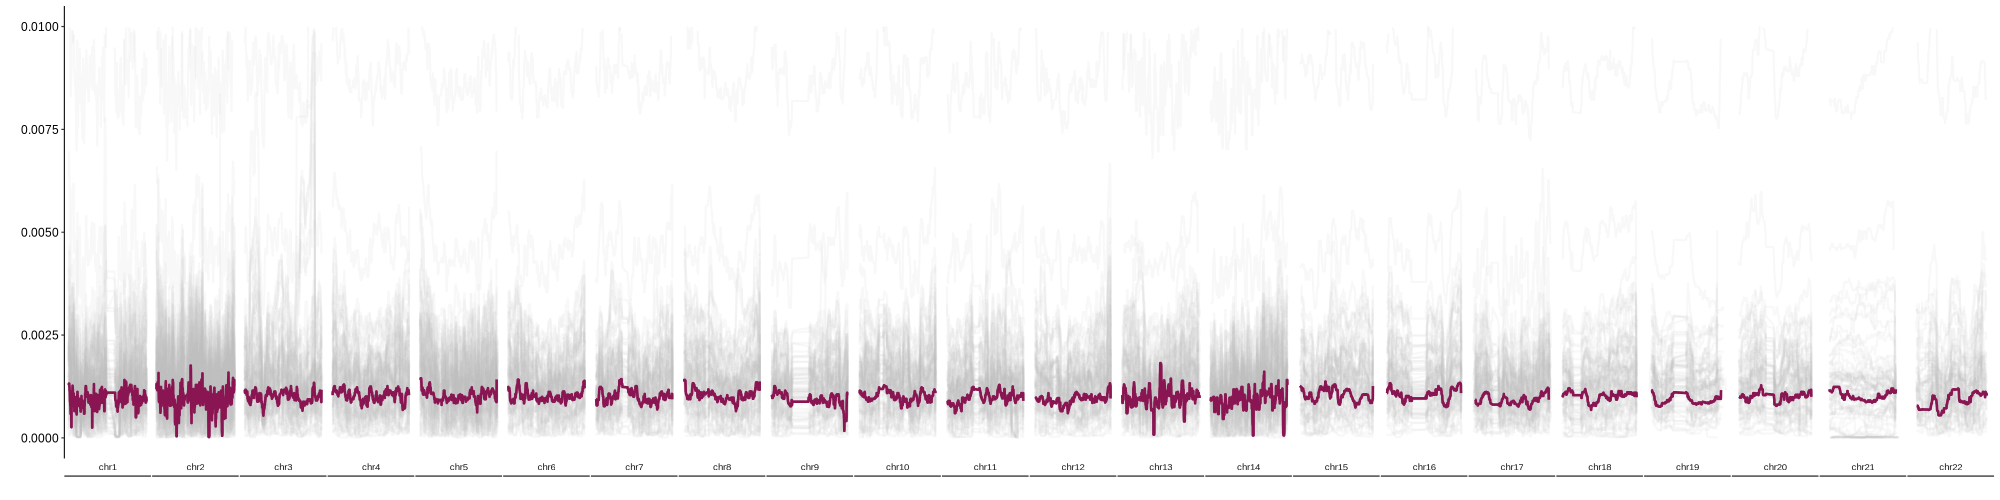

In [154]:
%%R -h 500 -w 2000
specific_species_new <- result %>% 
    filter(phylogenetic_group == 'New_world_monkeys') %>%
    filter(species == 'Pithecia_albicans') %>%
    group_by(species)

plot_diversity_genome_new <- result %>% 
    filter(phylogenetic_group == 'New_world_monkeys') %>%
    group_by(species) %>%
    ggplot(aes(x=position,y=rolling_diversity, group = species, col = species == 'Pithecia_albicans')) +
    geom_line(aes(alpha = ifelse(species == 'Pithecia_albicans', 1, 0.005)), size = 1) +
    geom_line(data = specific_species_new,aes(x=position,y=rolling_diversity), size = 1.2) +
    ggpubr::theme_pubr(legend = 'none') +
    scale_colour_manual(values = c('grey','#891652'))+
    facet_wrap(chrom~., scales = 'free_x', nrow=1, strip.position = 'bottom')+
    xlab('')+
    ylab('') +
    ylim(0,0.01)+
    theme(axis.text.x=element_blank(), #remove x axis labels
        axis.ticks.x=element_blank(),
        panel.spacing=unit(.08,"lines"),
        strip.background = element_blank())
    
plot_diversity_genome_new

In [157]:
%%R
tree_plot <- ggtree(treedata) +
    geom_tippoint(aes(color=pg_name), size=1.5)+
    scale_colour_manual(values = c('#240a34','#891652','#eabe6c','#db7552'))
    
plot_tree2 <- tree_plot  + 
    geom_strip(1, 58, barsize=4, color='#eabe6c') + #old_world
    geom_strip(59, 74, barsize=4, color='#240a34') + #Apes
    geom_strip(75, 153, barsize=4, color='#891652') + # new_world
    geom_strip(154, 194, barsize=4, color='#db7552') +
    theme(legend.position = 'none')

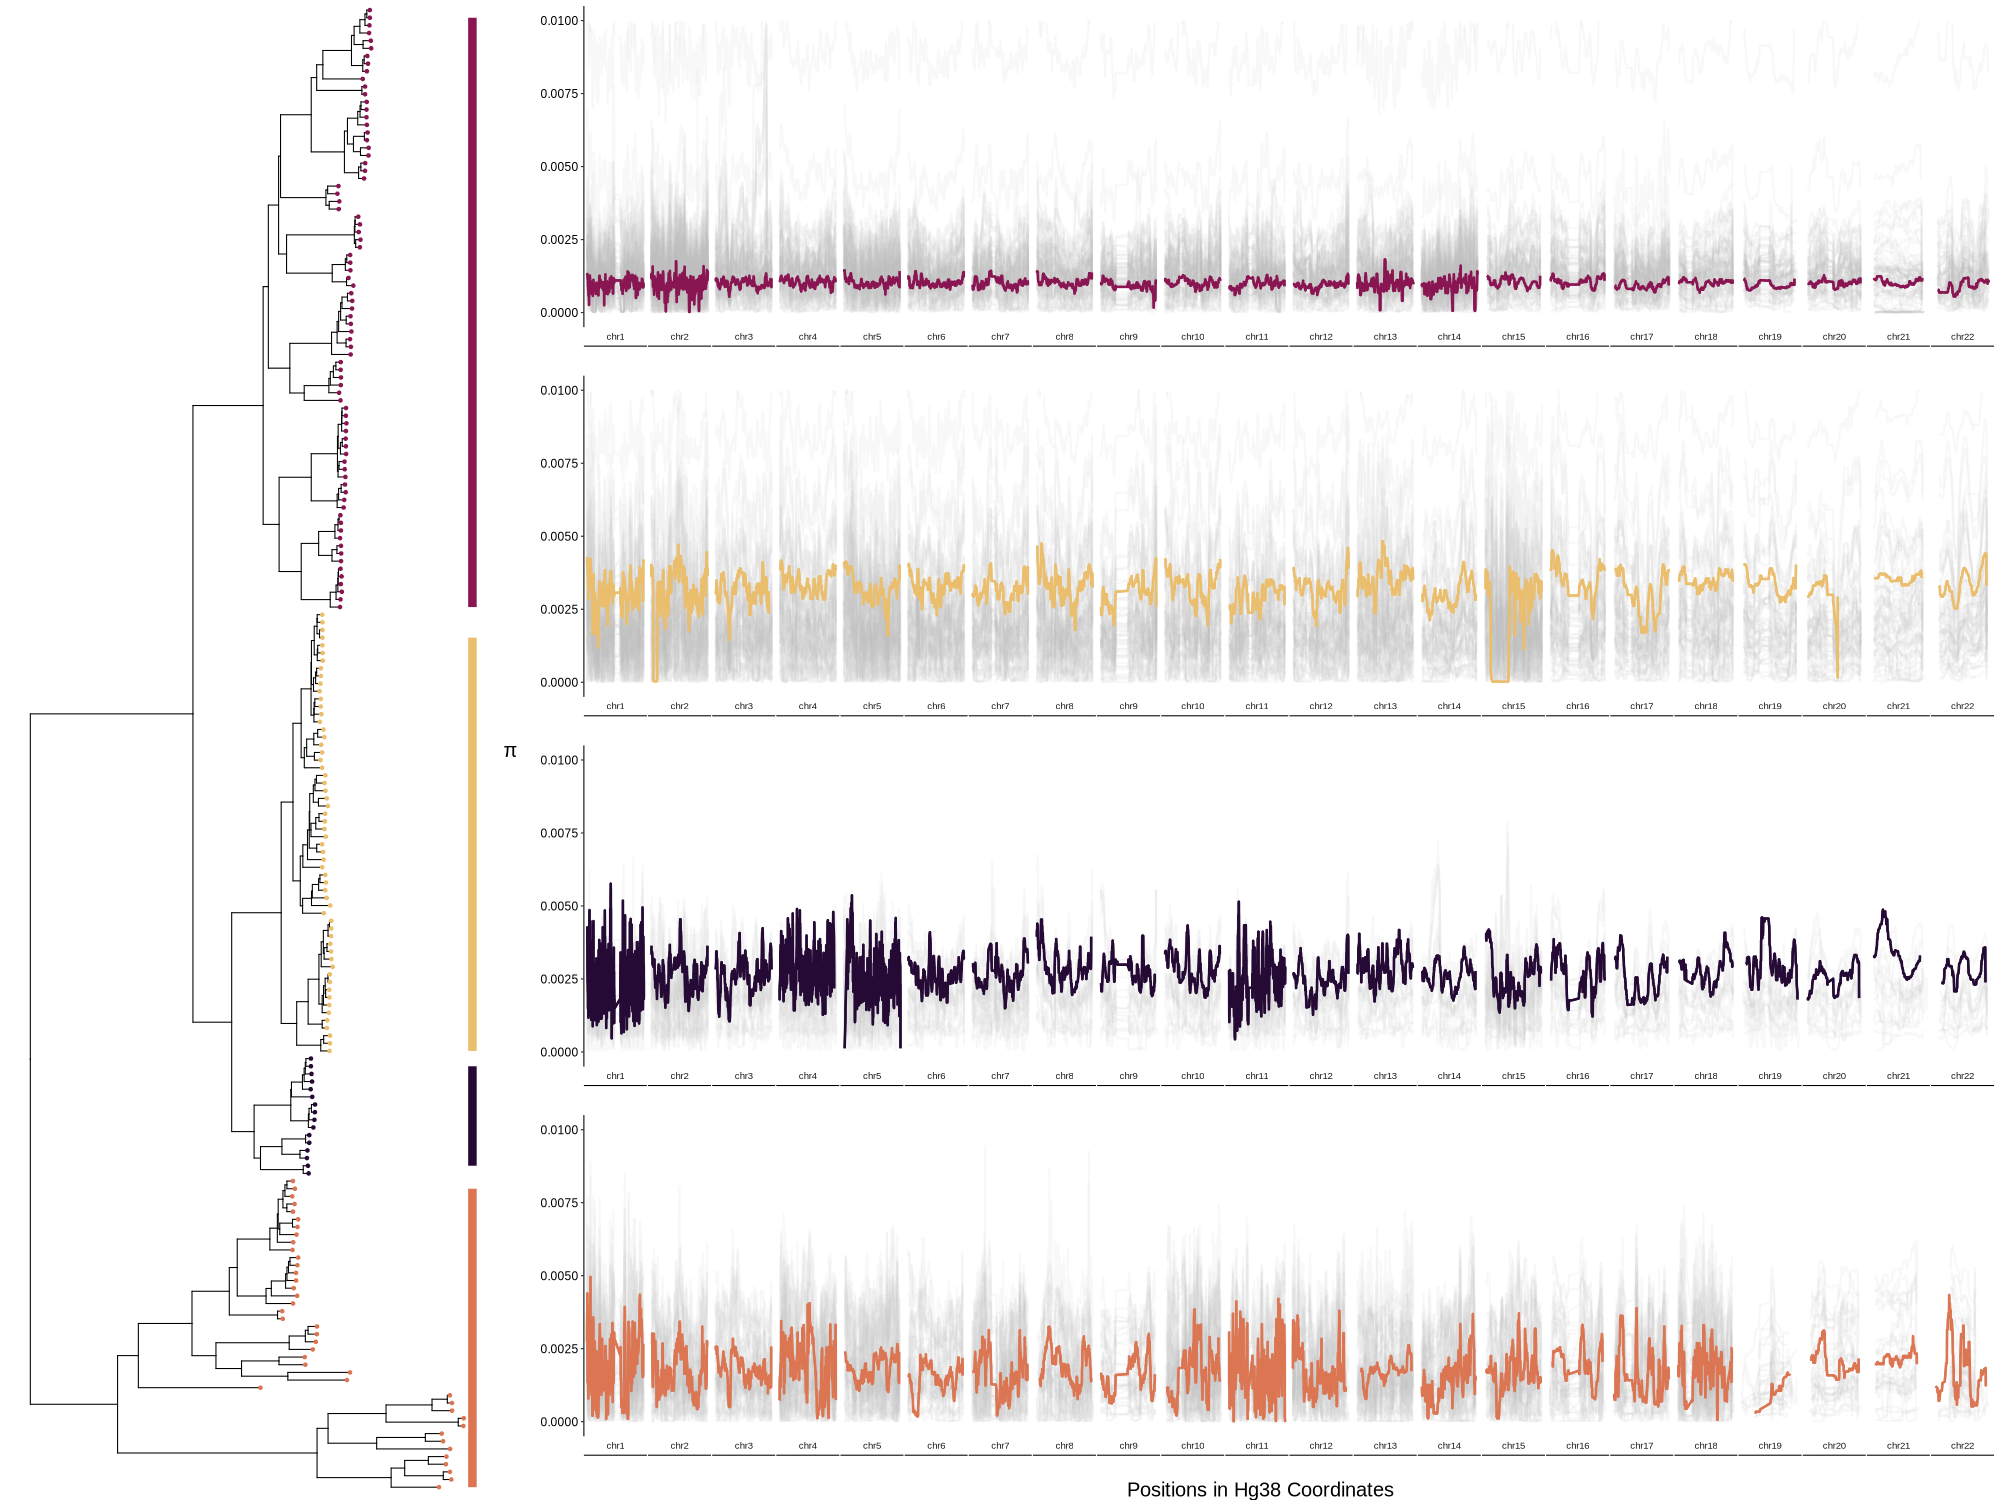

In [159]:
%%R -h 1500 -w 2000



sub_figure <- ggarrange(plot_diversity_genome_new,
                      plot_diversity_genome_old,
                      plot_diversity_genome_apes,
                      plot_diversity_genome_prosimians,
                      ncol=1,nrow=4, align = 'v')
sub_figure <- annotate_figure(sub_figure,
                bottom = text_grob("Positions in Hg38 Coordinates", color = "black", size = 20),
                left = text_grob("π", color = "black", size = 20))


figure <- ggarrange(plot_tree2, sub_figure, 
          widths = c(1,3),
          ncol=2)
figure

In [160]:
%%R
ggsave("../figures/figure1/figure1.png", 
    figure, 
    width = 15,    # Width in inches
    height = 8,    # Height in inches
    dpi = 600)  

# Relative Reduction Model

In [40]:
%%R
# #prepare data and save as dataframe()
#df <- read_delim('../results/stats/all_species_ne.combined.stats.filtered.csv')  %>% group_by(species) %>% mutate(rec_bin = ntile(cm_per_mb, 20))
#RR <- df %>%
   # group_by(species, Ne_median, phylogenetic_group, rec_bin) %>%
   #reframe(
    #    median_pi = median(diversity),
    # ) %>%
    #filter(rec_bin %in% c(1,20)) %>%
     #pivot_wider(
    #    names_from = rec_bin,
   #    values_from = median_pi,
  #       names_prefix = "bin_"
 #) %>%
#     mutate(relative_pi_difference = (bin_20 - bin_1)/bin_20)
#write_csv(RR, '../results/stats/relative_reduction_data.csv')

New names:
• `` -> `...1`
Rows: 3818191 Columns: 26
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (4): chrom, species, genus, phylogenetic_group
dbl (22): ...1, start, end, n_variants, diversity, n_singletons, singleton_p...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [41]:
df = pd.read_csv('../results/stats/relative_reduction_data.csv', sep = ',')
#stratify by phylogenetic grouping
Prosimians = df[df['phylogenetic_group']=='Prosimians']
Old_world_monkeys = df[df['phylogenetic_group']=='Old_world_monkeys']
New_world_monkeys = df[df['phylogenetic_group']=='New_world_monkeys']
Great_apes = df[df['phylogenetic_group']=='Great_apes']


In [42]:
Old_world_monkeys

,species,Ne_median,phylogenetic_group,bin_1,bin_20,relative_pi_difference
0,Allenopithecus_nigroviridis,46501.822025,Old_world_monkeys,0.001069,0.001558,0.313904
1,Allochrocebus_lhoesti,76989.112828,Old_world_monkeys,0.001605,0.002580,0.377907
2,Allochrocebus_preussi,95639.576207,Old_world_monkeys,0.002010,0.003205,0.372855
3,Allochrocebus_solatus,115782.076657,Old_world_monkeys,0.002520,0.003880,0.350515
36,Cercocebus_chrysogaster,61770.334711,Old_world_monkeys,0.000900,0.002070,0.565217
37,Cercocebus_lunulatus,82153.313361,Old_world_monkeys,0.001650,0.002660,0.379699
38,Cercocebus_torquatus,66093.267140,Old_world_monkeys,0.001170,0.002140,0.453271
39,Cercopithecus_ascanius,197026.989128,Old_world_monkeys,0.003398,0.006992,0.514034
40,Cercopithecus_cephus,244083.817008,Old_world_monkeys,0.003537,0.007585,0.533661
41,Cercopithecus_diana,156276.603612,Old_world_monkeys,0.002350,0.005060,0.535573


In [64]:
global_model = pm.Model()

with global_model:
# Data
    Ne = pm.Data('log10NE', np.log10(df['Ne_median']))
    rr = pm.Data('rr', df['relative_pi_difference'])

    sigma = pm.HalfNormal("sigma",sigma = 1)
    alpha = pm.Normal("alpha", 0, sigma = 0.1)
    beta = pm.Normal("beta", 0, sigma = 0.1)

    # Define likelihood
    likelihood = pm.Normal("relative_reduction", mu=alpha + beta * Ne, sigma=sigma, observed=rr)

In [65]:
with global_model:
    global_model_idata = pm.sample(1000, tune=500, target_accept=0.95, return_inferencedata=True,
                                                                progressbar=True, cores=4, chains=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, alpha, beta]


Output()

Sampling 4 chains for 500 tune and 1_000 draw iterations (2_000 + 4_000 draws total) took 4 seconds.


In [66]:
#az.to_netcdf(global_model_idata, '../results/RR_models/RR_globe_210225.nc')
#a =  global_model_idata.posterior.alpha.to_dataframe()
#a.to_csv("../results/RR_models/RR_alpha_global_210225.csv", sep=",")
#b =  global_model_idata.posterior.beta.to_dataframe()
#b.to_csv("../results/RR_models/RR_beta_global_210225.csv", sep=",")

In [90]:
relative_reduction_great_apes_model = pm.Model()

with relative_reduction_great_apes_model:
# Data
    Ne = pm.Data('log10NE', np.log10(Great_apes['Ne_median']))
    rr = pm.Data('rr', Great_apes['relative_pi_difference'])

    sigma = pm.HalfNormal("sigma",sigma = 1)
    alpha = pm.Normal("alpha", 0, sigma = 0.1)
    beta = pm.Normal("beta", 0, sigma = 0.1)

    # Define likelihood
    likelihood = pm.Normal("relative_reduction", mu=alpha + beta * Ne, sigma=sigma, observed=rr)

In [91]:
with relative_reduction_great_apes_model:
    relative_reduction_great_apes_model_idata = pm.sample(1000, tune=500, target_accept=0.95, return_inferencedata=True,
                                                                progressbar=True, cores=4, chains=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, alpha, beta]


Output()

Sampling 4 chains for 500 tune and 1_000 draw iterations (2_000 + 4_000 draws total) took 2 seconds.


In [97]:
#az.to_netcdf(relative_reduction_great_apes_model_idata, '../results/RR_models/RR_great_apes_210225.nc')
#a =  relative_reduction_great_apes_model_idata.posterior.alpha.to_dataframe()
#a.to_csv("../results/RR_models/RR_alpha_great_apes_210225.csv", sep=",")
#b =  relative_reduction_great_apes_model_idata.posterior.beta.to_dataframe()
#b.to_csv("../results/RR_models/RR_beta_great_apes_210225.csv", sep=",")

In [98]:
relative_reduction_New_world_monkeys_model = pm.Model()

with relative_reduction_New_world_monkeys_model:
# Data
    Ne = pm.Data('log10NE', np.log10(New_world_monkeys['Ne_median']))
    rr = pm.Data('rr', New_world_monkeys['relative_pi_difference'])

    sigma = pm.HalfNormal("sigma",sigma = 1)
    alpha = pm.Normal("alpha", 0, sigma = 0.1)
    beta = pm.Normal("beta", 0, sigma = 0.1)

    # Define likelihood
    likelihood = pm.Normal("relative_reduction", mu=alpha + beta * Ne, sigma=sigma, observed=rr)
with relative_reduction_New_world_monkeys_model:
    relative_reduction_New_world_monkeys_model_idata = pm.sample(1000, tune=500, target_accept=0.95, return_inferencedata=True,
                                                                progressbar=True, cores=4, chains=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, alpha, beta]


Output()

Sampling 4 chains for 500 tune and 1_000 draw iterations (2_000 + 4_000 draws total) took 3 seconds.


In [99]:
#az.to_netcdf(relative_reduction_New_world_monkeys_model_idata, '../results/RR_models/RR_New_world_monkeys_210225.nc')
#a =  relative_reduction_New_world_monkeys_model_idata.posterior.alpha.to_dataframe()
#a.to_csv("../results/RR_models/RR_alpha_New_world_monkeys_210225.csv", sep=",")
#b =  relative_reduction_New_world_monkeys_model_idata.posterior.beta.to_dataframe()
#b.to_csv("../results/RR_models/RR_beta_New_world_monkeys_210225.csv", sep=",")

In [43]:
relative_reduction_Old_world_monkeys_model = pm.Model()

with relative_reduction_Old_world_monkeys_model:
# Data
    Ne = pm.Data('log10NE', np.log10(Old_world_monkeys['Ne_median']))
    rr = pm.Data('rr', Old_world_monkeys['relative_pi_difference'])

    sigma = pm.HalfNormal("sigma",sigma = 1)
    alpha = pm.Normal("alpha", 0, sigma = 0.1)
    beta = pm.Normal("beta", 0, sigma = 0.1)

    # Define likelihood
    likelihood = pm.Normal("relative_reduction", mu=alpha + beta * Ne, sigma=sigma, observed=rr)
with relative_reduction_Old_world_monkeys_model:
    relative_reduction_Old_world_monkeys_model_idata = pm.sample(1000, tune=500, target_accept=0.95, return_inferencedata=True,
                                                                progressbar=True, cores=4, chains=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, alpha, beta]


Output()

Sampling 4 chains for 500 tune and 1_000 draw iterations (2_000 + 4_000 draws total) took 3 seconds.


In [44]:
#az.to_netcdf(relative_reduction_Old_world_monkeys_model_idata, '../results/RR_models/RR_Old_world_monkeys_210225.nc')
#a =  relative_reduction_Old_world_monkeys_model_idata.posterior.alpha.to_dataframe()
#a.to_csv("../results/RR_models/RR_alpha_Old_world_monkeys_210225.csv", sep=",")
#b =  relative_reduction_Old_world_monkeys_model_idata.posterior.beta.to_dataframe()
#b.to_csv("../results/RR_models/RR_beta_Old_world_monkeys_210225.csv", sep=",")

In [45]:
relative_reduction_Prosimians_model = pm.Model()

with relative_reduction_Prosimians_model:
# Data
    Ne = pm.Data('log10NE', np.log10(Prosimians['Ne_median']))
    rr = pm.Data('rr', Prosimians['relative_pi_difference'])

    sigma = pm.HalfNormal("sigma",sigma = 1)
    alpha = pm.Normal("alpha", 0, sigma = 0.1)
    beta = pm.Normal("beta", 0, sigma = 0.1)

    # Define likelihood
    likelihood = pm.Normal("relative_reduction", mu=alpha + beta * Ne, sigma=sigma, observed=rr)
with relative_reduction_Prosimians_model:
    relative_reduction_Prosimians_model_idata = pm.sample(1000, tune=500, target_accept=0.95, return_inferencedata=True,
                                                                progressbar=True, cores=4, chains=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, alpha, beta]


Output()

Sampling 4 chains for 500 tune and 1_000 draw iterations (2_000 + 4_000 draws total) took 3 seconds.


In [47]:
#az.to_netcdf(relative_reduction_Prosimians_model_idata, '../results/RR_models/RR_Prosimians_210225.nc')
#a =  relative_reduction_Prosimians_model_idata.posterior.alpha.to_dataframe()
#a.to_csv("../results/RR_models/RR_alpha_Prosimians_210225.csv", sep=",")
#b =  relative_reduction_Prosimians_model_idata.posterior.beta.to_dataframe()
#b.to_csv("../results/RR_models/RR_beta_Prosimians_210225.csv", sep=",")

# Relative Reduction Figures

In [5]:
%%R
diff_df <- read_delim('../results/stats/relative_reduction_data.csv', ',')

Rows: 178 Columns: 6
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (2): species, phylogenetic_group
dbl (4): Ne_median, bin_1, bin_20, relative_pi_difference

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [6]:
%%R
diff_df

# A tibble: 178 × 6
   species   Ne_median phylogenetic_group   bin_1  bin_20 relative_pi_difference
   <chr>         <dbl> <chr>                <dbl>   <dbl>                  <dbl>
 1 Allenopi…    46502. Old_world_monkeys  0.00107 0.00156                  0.314
 2 Allochro…    76989. Old_world_monkeys  0.00160 0.00258                  0.378
 3 Allochro…    95640. Old_world_monkeys  0.00201 0.00320                  0.373
 4 Allochro…   115782. Old_world_monkeys  0.00252 0.00388                  0.351
 5 Alouatta…    49595. New_world_monkeys  0.00105 0.00176                  0.403
 6 Alouatta…    20571. New_world_monkeys  0.00055 0.00073                  0.247
 7 Alouatta…    62698. New_world_monkeys  0.00119 0.00222                  0.466
 8 Alouatta…    59635. New_world_monkeys  0.00130 0.00206                  0.370
 9 Alouatta…    58775. New_world_monkeys  0.00124 0.00209                  0.403
10 Alouatta…    62095. New_world_monkeys  0.00123 0.00215                  0.428
# ℹ 168 

Rows: 4000 Columns: 3
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (3): chain, draw, alpha

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 4000 Columns: 3
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (3): chain, draw, beta

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


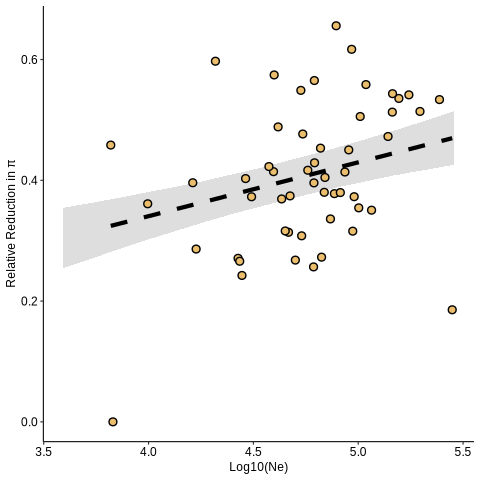

In [8]:
%%R
## old world monkeys
alpha_old <- read_delim('../results/RR_models/RR_alpha_Old_world_monkeys_210225.csv', delim = ',')
beta_old <- read_delim('../results/RR_models/RR_beta_Old_world_monkeys_210225.csv', delim = ',')

# Sample regressions 
# Use the function
x_values_o <- c()
lower_bounds_o <- c()
upper_bounds_o <- c()

# Calculate the credibility intervals for each x value
for (i in log10(diff_df$Ne_median)) {
    cred_int <- credibility_interval(i, beta_old$beta, alpha_old$alpha)
    x_values_o <- c(x_values_o, i)
    lower_bounds_o <- c(lower_bounds_o, cred_int[1])
    upper_bounds_o <- c(upper_bounds_o, cred_int[2])
}

# Create a data frame
mean_reg_line_o <- data.frame(
    x = x_values_o,
    lower_bound = lower_bounds_o,
    upper_bound = upper_bounds_o
)

old_world_rr <- diff_df %>%
    filter(phylogenetic_group == 'Old_world_monkeys') %>%
    ggplot()+
    ggpubr::theme_pubr(legend = 'none')+
    geom_ribbon(data=mean_reg_line_o, aes(x= x, ymin = lower_bound, ymax = upper_bound), fill='grey', alpha = .5)+
    geom_line(aes(x=log10(Ne_median), y=(mean(alpha_old$alpha))+(mean(beta_old$beta)*log10(Ne_median))), lty = 2, size =2)+
    geom_point(aes(x=log10(Ne_median),y=relative_pi_difference, fill=phylogenetic_group), color = 'black', size = 3, alpha = 1, shape = 21, stroke = 1)+
    scale_fill_manual(values=c('#eabe6c')) +
    ylab("Relative Reduction in π")+
    xlab('Log10(Ne)')
print(old_world_rr)

Rows: 4000 Columns: 3
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (3): chain, draw, alpha

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 4000 Columns: 3
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (3): chain, draw, beta

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


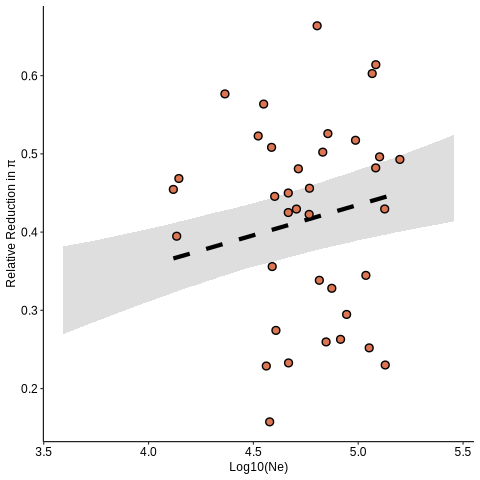

In [17]:
%%R
## prosimians
alpha_prosimians <- read_delim('../results/RR_models/RR_alpha_Prosimians_210225.csv', delim = ',')
beta_Prosimians<- read_delim('../results/RR_models/RR_beta_Prosimians_210225.csv', delim = ',')

# Sample regressions 
# Use the function
x_values_o <- c()
lower_bounds_o <- c()
upper_bounds_o <- c()

# Calculate the credibility intervals for each x value
for (i in log10(diff_df$Ne_median)) {
    cred_int <- credibility_interval(i, beta_Prosimians$beta, alpha_prosimians$alpha)
    x_values_o <- c(x_values_o, i)
    lower_bounds_o <- c(lower_bounds_o, cred_int[1])
    upper_bounds_o <- c(upper_bounds_o, cred_int[2])
}

# Create a data frame
mean_reg_line_o <- data.frame(
    x = x_values_o,
    lower_bound = lower_bounds_o,
    upper_bound = upper_bounds_o
)

prosimians_rr <- diff_df %>%
    filter(phylogenetic_group == 'Prosimians') %>%
    ggplot()+
    ggpubr::theme_pubr(legend = 'none')+
    geom_ribbon(data=mean_reg_line_o, aes(x= x, ymin = lower_bound, ymax = upper_bound), fill='grey', alpha = .5)+
    geom_line(aes(x=log10(Ne_median), y=(mean(alpha_prosimians$alpha))+(mean(beta_Prosimians$beta)*log10(Ne_median))), lty = 2, size =2)+
    geom_point(aes(x=log10(Ne_median),y=relative_pi_difference, fill=phylogenetic_group), color = 'black', size = 3, alpha = 1, shape = 21, stroke = 1)+
    scale_fill_manual(values=c('#db7552')) +
    ylab("Relative Reduction in π")+
    xlab('Log10(Ne)')
print(prosimians_rr)

Rows: 4000 Columns: 3
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (3): chain, draw, alpha



ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 4000 Columns: 3
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (3): chain, draw, beta

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


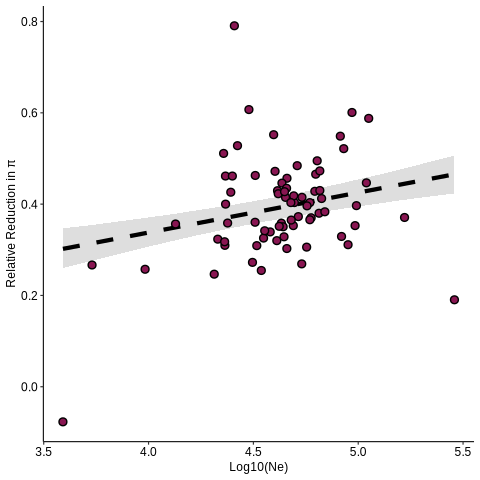

In [18]:
%%R
## New World
alpha_new <- read_delim('../results/RR_models/RR_alpha_New_world_monkeys_210225.csv', delim = ',')
beta_new<- read_delim('../results/RR_models/RR_beta_New_world_monkeys_210225.csv', delim = ',')

# Sample regressions 
# Use the function
x_values_o <- c()
lower_bounds_o <- c()
upper_bounds_o <- c()

# Calculate the credibility intervals for each x value
for (i in log10(diff_df$Ne_median)) {
    cred_int <- credibility_interval(i, beta_new$beta, alpha_new$alpha)
    x_values_o <- c(x_values_o, i)
    lower_bounds_o <- c(lower_bounds_o, cred_int[1])
    upper_bounds_o <- c(upper_bounds_o, cred_int[2])
}

# Create a data frame
mean_reg_line_o <- data.frame(
    x = x_values_o,
    lower_bound = lower_bounds_o,
    upper_bound = upper_bounds_o
)

new_world_rr <- diff_df %>%
    filter(phylogenetic_group == 'New_world_monkeys') %>%
    ggplot()+
    ggpubr::theme_pubr(legend = 'none')+
    geom_ribbon(data=mean_reg_line_o, aes(x= x, ymin = lower_bound, ymax = upper_bound), fill='grey', alpha = .5)+
    geom_line(aes(x=log10(Ne_median), y=(mean(alpha_new$alpha))+(mean(beta_new$beta)*log10(Ne_median))), lty = 2, size =2)+
    geom_point(aes(x=log10(Ne_median),y=relative_pi_difference, fill=phylogenetic_group), color = 'black', size = 3, alpha = 1, shape = 21, stroke = 1)+
    scale_fill_manual(values=c('#891652')) +
    ylab("Relative Reduction in π")+
    
    xlab('Log10(Ne)')
print(new_world_rr)

Rows: 4000 Columns: 3
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (3): chain, draw, alpha



ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 4000 Columns: 3
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (3): chain, draw, beta

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


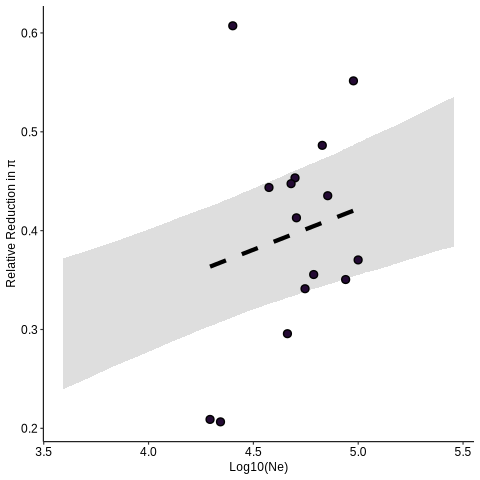

In [19]:
%%R
## Apes
alpha_apes <- read_delim('../results/RR_models/RR_alpha_great_apes_210225.csv', delim = ',')
beta_apes <- read_delim('../results/RR_models/RR_beta_great_apes_210225.csv', delim = ',')

# Sample regressions 
# Use the function
x_values_o <- c()
lower_bounds_o <- c()
upper_bounds_o <- c()

# Calculate the credibility intervals for each x value
for (i in log10(diff_df$Ne_median)) {
    cred_int <- credibility_interval(i, beta_apes$beta, alpha_apes$alpha)
    x_values_o <- c(x_values_o, i)
    lower_bounds_o <- c(lower_bounds_o, cred_int[1])
    upper_bounds_o <- c(upper_bounds_o, cred_int[2])
}

# Create a data frame
mean_reg_line_o <- data.frame(
    x = x_values_o,
    lower_bound = lower_bounds_o,
    upper_bound = upper_bounds_o
)

apes_rr <- diff_df %>%
    filter(phylogenetic_group == 'Great_apes') %>%
    ggplot()+
    ggpubr::theme_pubr(legend = 'none')+
    geom_ribbon(data=mean_reg_line_o, aes(x= x, ymin = lower_bound, ymax = upper_bound), fill='grey', alpha = .5)+
    geom_line(aes(x=log10(Ne_median), y=(mean(alpha_apes$alpha))+(mean(beta_apes$beta)*log10(Ne_median))), lty = 2, size =2)+
    geom_point(aes(x=log10(Ne_median),y=relative_pi_difference, fill=phylogenetic_group), color = 'black', size = 3, alpha = 1, shape = 21, stroke = 1)+
    scale_fill_manual(values=c('#240a34')) +
    ylab("Relative Reduction in π")+
    xlab('Log10(Ne)')
print(apes_rr)

In [20]:
%%R
# Combine all dataframes into one and add a 'group' column
beta_global <- read_delim('../results/RR_models/RR_beta_global_210225.csv', delim = ',')
beta_global

Rows: 4000 Columns: 3
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (3): chain, draw, beta

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
# A tibble: 4,000 × 3
   chain  draw   beta
   <dbl> <dbl>  <dbl>
 1     0     0 0.114 
 2     0     1 0.114 
 3     0     2 0.115 
 4     0     3 0.116 
 5     0     4 0.116 
 6     0     5 0.112 
 7     0     6 0.114 
 8     0     7 0.0902
 9     0     8 0.0913
10     0     9 0.0861
# ℹ 3,990 more rows
# ℹ Use `print(n = ...)` to see more rows


In [21]:
%%R
combined_data <- bind_rows(
  mutate(beta_Prosimians, group = 'Prosimians'),
  mutate(beta_old, group = 'Old World Monkeys'),
  mutate(beta_new, group = 'New World Monkeys'),
  mutate(beta_apes, group = 'Apes'),
  mutate(beta_global, group = 'Global')
)

R[write to console]: Picking joint bandwidth of 0.0033



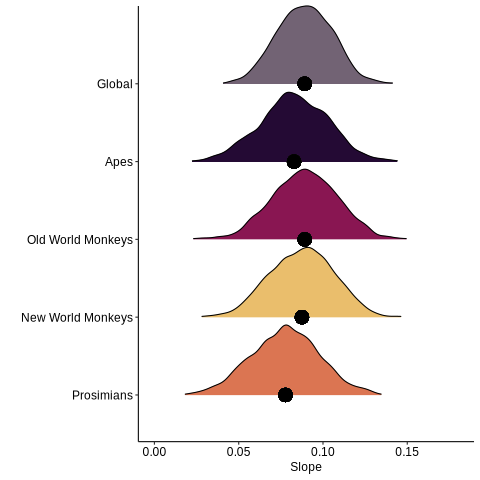

In [22]:
%%R
# Set factor levels to control the order
combined_data$group <- factor(combined_data$group, 
                            levels = c('Prosimians', 
                                     'New World Monkeys', 
                                    'Old World Monkeys',
                                     'Apes',
                                     'Global'))

# Create a joyplot
rr_betas <- ggplot() +
  geom_density_ridges_gradient(data=combined_data, aes(x = beta, y = group, fill = group),
                              alpha = .5, scale = 1, rel_min_height = 0.01) +
  scale_fill_manual(values = c('#db7552','#eabe6c','#891652','#240a34', '#726374')) +
  theme_ridges(font_size = 13, grid = F) +
  xlab('Slope') +
  ylab('') +
  ggpubr::theme_pubr()

# Add vertical lines for the mean of each group
for(group in levels(combined_data$group)) {
  rr_betas <- rr_betas + 
    geom_point(data = filter(combined_data, group == !!group), 
               aes(x = mean(beta), y = group, color = group), 
               size = 6, alpha = .5, col = 'black') +
      theme(legend.position = 'none')
}

# Print the plot
print(rr_betas)

Rows: 4000 Columns: 3
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (3): chain, draw, alpha

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 4000 Columns: 3
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (3): chain, draw, beta

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


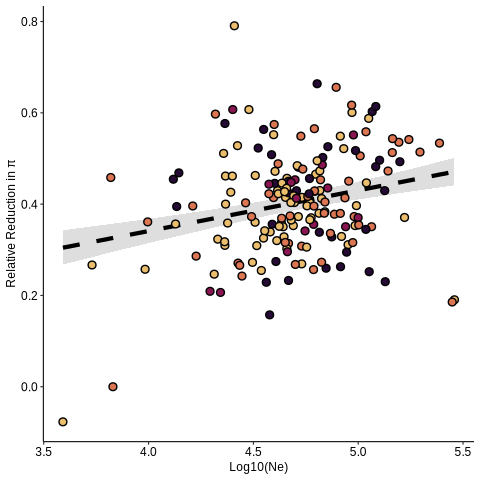

In [23]:
%%R 
a <- read_delim("../results/RR_models/RR_alpha_global_210225.csv", delim=",")
b <- read_delim("../results/RR_models/RR_beta_global_210225.csv", delim = ",")
           

# Use the function
x_values <- c()
lower_bounds <- c()
upper_bounds <- c()


for (i in log10(diff_df$Ne_median)) {
    cred_int <- credibility_interval(i, b$beta, a$alpha)
    x_values <- c(x_values, i)
    lower_bounds <- c(lower_bounds, cred_int[1])
    upper_bounds <- c(upper_bounds, cred_int[2])
}

# Create a data frame
mean_reg_line <- data.frame(
    x = x_values,
    lower_bound = lower_bounds,
    upper_bound = upper_bounds
)

model_relative_reduction <- ggplot()+
    ggpubr::theme_pubr(legend = 'none')+
    geom_ribbon(data=mean_reg_line, aes(x= x, ymin = lower_bound, ymax = upper_bound), fill='grey', alpha = .5)+
    geom_line(aes(x=log10(diff_df$Ne_median), y=(mean(a$alpha))+(mean(b$beta)*log10(diff_df$Ne_median))), lty = 2, size =2)+
    geom_point(data = diff_df, aes(x=log10(Ne_median),y=relative_pi_difference, fill=phylogenetic_group), color = 'black', size = 3, alpha = 1, shape = 21, stroke = 1)+
    scale_fill_manual(values=c('#891652','#eabe6c','#db7552','#240a34')) +
    ylab("Relative Reduction in π")+
    xlab('Log10(Ne)')
model_relative_reduction

In [62]:
%%R
ggsave("../figures/figure2/global.png",model_relative_reduction, width = 15, height = 12, dpi = 600)
ggsave("../figures/figure2/rr_apes.png",apes_rr, width = 15, height = 12, dpi = 600)
ggsave("../figures/figure2/rr_new.png",new_world_rr, width = 15, height = 12, dpi = 600)
ggsave("../figures/figure2/rr_old.png",old_world_rr, width = 15, height = 12, dpi = 600)
ggsave("../figures/figure2/rr_prosimians.png",prosimians_rr, width = 15, height = 12, dpi = 600)
ggsave("../figures/figure2/rr_global_betas.png",rr_betas, width = 15, height = 12, dpi = 600)



R[write to console]: Picking joint bandwidth of 0.0033



### Figure 2

Rows: 3560 Columns: 6
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (1): species
dbl (5): rec_bin, median_pi, median_cm_mb, median_singleton_p, median_tajimas_d

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


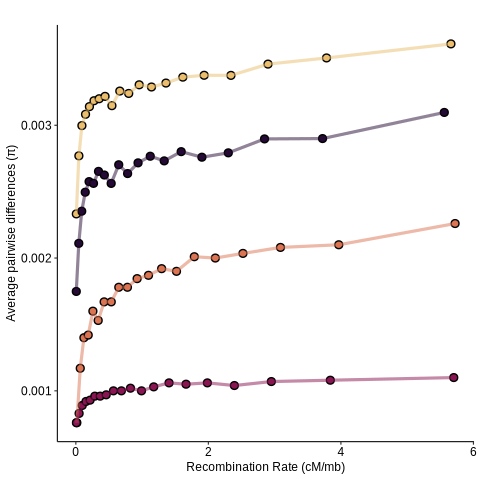

In [24]:
%%R
df <- read_delim('../results/stats/summary_stats_in_bins.csv', delim = ',')
figure2a <- df %>%
    filter(species %in% c('Lemur_catta','Pongo_abelii','Macaca_fascicularis','Pithecia_albicans')) %>%
    ggplot(aes(x=median_cm_mb,y=median_pi,col=species))+
    geom_point(aes(fill=species),color = 'black', size = 3, alpha = 1, shape = 21, stroke = 1)+
    geom_line(alpha = .5, size =1.5)+
    scale_fill_manual(values = c('#db7552','#eabe6c','#891652', '#240a34'))+
    scale_colour_manual(values = c('#db7552','#eabe6c','#891652', '#240a34'))+
    labs(x = "Recombination Rate (cM/mb)", y = "Average pairwise differences (π)", title = "", size = 55) +
    ggpubr::theme_pubr(legend='none')
figure2a

R[write to console]: Picking joint bandwidth of 0.0033



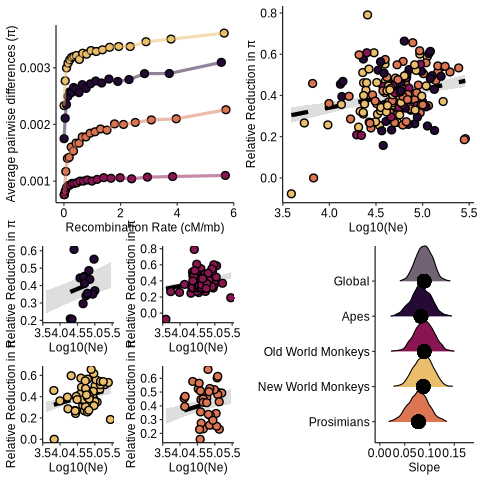

In [28]:
%%R
fig2 <- ggarrange(figure2a, model_relative_reduction, ggarrange(apes_rr, new_world_rr, old_world_rr, prosimians_rr, ncol = 2, nrow= 2),rr_betas, 
         ncol=2, nrow=2)
fig2

In [29]:
%%R
ggsave("../figures/figure2/figure2_combined.png",fig2, width = 15, height = 12, dpi = 600)

# Example binned pi ~ recombination

In [10]:
#%%R
# df <- read_delim('../results/stats/all_species_ne.combined.stats.filtered.csv', delim = ',') %>% group_by(species) %>% mutate(rec_bin = ntile(cm_per_mb, 20))
# summaries_in_bins <- df %>%
#     group_by(species,rec_bin) %>%
#     reframe(
#         median_pi = median(diversity),
#         median_cm_mb = median(cm_per_mb),
#         median_singleton_p = median(singleton_proportion),
#         median_tajimas_d = median(tajima_d)
#     ) 
# write_csv(summaries_in_bins, '../results/stats/summary_stats_in_bins.csv')


In [6]:
%%R
df <- read_delim('../results/stats/summary_stats_in_bins.csv', delim = ',')
df

Rows: 3560 Columns: 6
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (1): species
dbl (5): rec_bin, median_pi, median_cm_mb, median_singleton_p, median_tajimas_d

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
# A tibble: 3,560 × 6
   species    rec_bin median_pi median_cm_mb median_singleton_p median_tajimas_d
   <chr>        <dbl>     <dbl>        <dbl>              <dbl>            <dbl>
 1 Allenopit…       1   0.00107      0.00785              0.773          -0.148 
 2 Allenopit…       2   0.00118      0.0469               0.761          -0.107 
 3 Allenopit…       3   0.00125      0.0930               0.757          -0.0964
 4 Allenopit…       4   0.00127      0.149                0.749          -0.0688
 5 Allenopit…       5   0.00133      0.209                0.75           -0.0728
 6 Allenopit…       6   0.00135      0.27

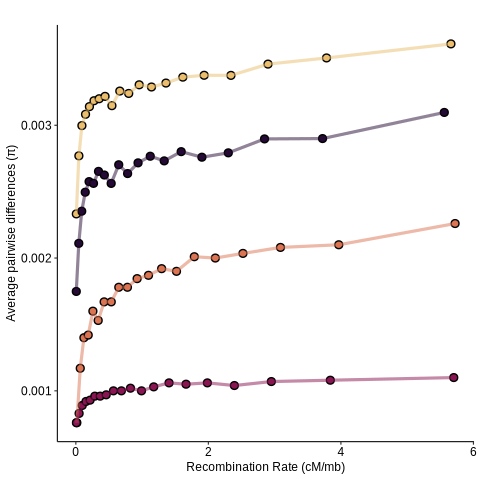

In [26]:
%%R
figure2a <- df %>%
    filter(species %in% c('Lemur_catta','Pongo_abelii','Macaca_fascicularis','Pithecia_albicans')) %>%
    ggplot(aes(x=median_cm_mb,y=median_pi,col=species))+
    geom_point(aes(fill=species),color = 'black', size = 3, alpha = 1, shape = 21, stroke = 1)+
    geom_line(alpha = .5, size =1.5)+
    scale_fill_manual(values = c('#db7552','#eabe6c','#891652', '#240a34'))+
    scale_colour_manual(values = c('#db7552','#eabe6c','#891652', '#240a34'))+
    labs(x = "Recombination Rate (cM/mb)", y = "Average pairwise differences (π)", title = "", size = 55) +
    ggpubr::theme_pubr(legend='none')
figure2a

In [28]:
%%R
ggsave("../figures/figure2/figure2a.png", 
    figure2a, 
    width = 15,    # Width in inches
    height = 8,    # Height in inches
    dpi = 600)  

`geom_smooth()` using formula = 'y ~ x'


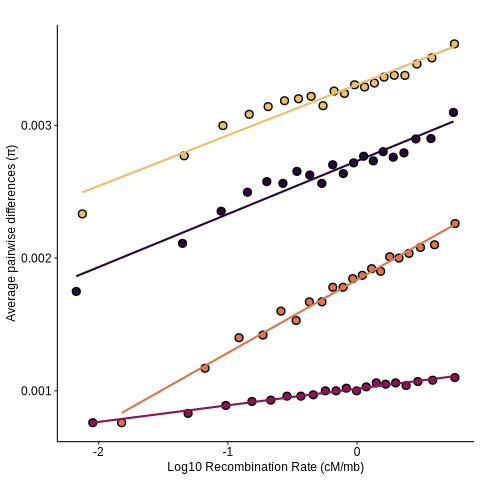

In [70]:
%%R
figure3a <- df %>%
    filter(species %in% c('Lemur_catta','Pongo_abelii','Macaca_fascicularis','Pithecia_albicans')) %>%
    ggplot(aes(x=log10(median_cm_mb),y=median_pi,col=species))+
    geom_point(aes(fill=species),color = 'black', size = 3, alpha = 1, shape = 21, stroke = 1)+
    geom_smooth(method='lm', se=FALSE)+
    scale_fill_manual(values = c('#db7552','#eabe6c','#891652', '#240a34'))+
    scale_colour_manual(values = c('#db7552','#eabe6c','#891652', '#240a34'))+
    labs(x = "Log10 Recombination Rate (cM/mb)", y = "Average pairwise differences (π)", title = "", size = 55) +
    ggpubr::theme_pubr(legend='none')
figure3a

In [71]:
%%R
ggsave("../figures/figure3/figure3a.png", 
    figure3a, 
    width = 15,    # Width in inches
    height = 8,    # Height in inches
    dpi = 600)  

`geom_smooth()` using formula = 'y ~ x'


# Diversity ~ Recombination analysis

### Model

In [5]:
df = pd.read_csv('../results/stats/all_species_ne.combined.stats.filtered.csv', sep=',')
df = df[df['cm_per_mb']!=0]

In [6]:
# standardize and center for better prior 
df['z_pi'] = df.groupby('species')['diversity'].transform(lambda x: (x - x.mean()) / x.std())

df['log10_cm_per_mb'] = np.log10(df['cm_per_mb'])
df['z_cm_per_mb'] = df.groupby('species')['cm_per_mb'].transform(lambda x: (x - x.mean()) / x.std())

df['z_ne'] = (np.log10(df['Ne_median'])-np.log10(df['Ne_median']).mean())/np.log10(df['Ne_median']).std()

In [6]:
py_df = df[['species','Ne_median','z_pi','z_cm_per_mb','z_ne']]
### Step 3: make data in a pymc3 format 
unique_Species_log = py_df['species'].unique()
species_lookup_log = dict(zip(unique_Species_log, range(len(unique_Species_log))))
Ne_log =  (pd.DataFrame([py_df['species'], py_df['z_ne']]).transpose()).drop_duplicates()
pi_log = py_df['z_pi'].values
recombinationrate_log = py_df['z_cm_per_mb'].values
species_log = py_df['species'].replace(species_lookup_log).values

/tmp/54621377/ipykernel_3509709/827164987.py:8: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  species_log = py_df['species'].replace(species_lookup_log).values


In [7]:
### step 4: formulate the model
hierarchical_model = pm.Model(coords = {"Species": unique_Species_log, 
                                "obs_id": np.arange(len(recombinationrate_log))})
with hierarchical_model:
    # Data
    recomb = pm.Data('recomb', recombinationrate_log, dims = 'obs_id')
    pi = pm.Data('pi', pi_log, dims = 'obs_id')
    sp = pm.Data('sp',species_log, dims = 'obs_id')
    Ne =  pm.Data('Ne', Ne_log['z_ne'], dims = 'Species')

    #Hyperpriors:
    g0 = pm.Normal("g0", mu=0, sigma=1)
    g1 = pm.Normal("g1", mu=0, sigma=1)
    h0 = pm.Normal("h0", mu=0, sigma=1)
    h1 = pm.Normal("h1", mu=0, sigma=1)

    mu_a = g0+g1*Ne
    mu_b = h0+h1*Ne
    sigma_a = pm.HalfNormal("sigma_a", 1)
    sigma_b = pm.HalfNormal("sigma_b", 1)
    # Varying intercepts:
    a_offset = pm.Normal("a_offset", 0, sigma=1, dims="Species")
    a = pm.Deterministic("a", mu_a + a_offset * sigma_a, dims="Species")
    # Varying slopes:
    b_offset = pm.Normal("b_offset", 0, sigma=1, dims="Species")
    b = pm.Deterministic("b", mu_b + b_offset * sigma_b, dims="Species")
    # Expected value per species:
    y = a[sp] + b[sp] * recomb
    # Model error
    sigma = pm.HalfNormal("sigma", 0.01)
    Pi = pm.Normal("Pi", mu=y, sigma=sigma, observed=pi, dims="obs_id")

In [ ]:
# Sample posterior
with hierarchical_model:
    hierarchical_model_idata = pm.sample(2000, tune=1000, target_accept=0.99, return_inferencedata=True,
                                                               progressbar=True, cores=12, chains=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 12 jobs)
NUTS: [g0, g1, h0, h1, sigma_a, sigma_b, a_offset, b_offset, sigma]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 70214 seconds.


In [ ]:

# az.to_netcdf(hierarchical_model_idata, '../results/Full_model/hierarchical_model_250225.nc')

# g0 = hierarchical_model_idata.posterior.g0.to_dataframe()
# g0.to_csv("../results/Full_model/hierarchical_model_g0_250225.csv", sep=",")

# g1 = hierarchical_model_idata.posterior.g1.to_dataframe()
# g1.to_csv("../results/Full_model/hierarchical_model_g1_250225.csv", sep=",")

# h0 = hierarchical_model_idata.posterior.h0.to_dataframe()
# h0.to_csv("../results/Full_model/hierarchical_model_h0_250225.csv", sep=",")

# h1 = hierarchical_model_idata.posterior.h1.to_dataframe()
# h1.to_csv("../results/Full_model/hierarchical_model_h1_250225.csv", sep=",")

# sigma_a = hierarchical_model_idata.posterior.sigma_a.to_dataframe()
# sigma_a.to_csv("../results/Full_model/hierarchical_model_sigma_a_250225.csv", sep=",")

# sigma_b = hierarchical_model_idata.posterior.sigma_b.to_dataframe()
# sigma_b.to_csv("../results/Full_model/hierarchical_model_sigma_b_250225.csv", sep=",")

# a = hierarchical_model_idata.posterior.a.to_dataframe()
# a.to_csv("../results/Full_model/hierarchical_model_a_250225.csv", sep=",")

# b = hierarchical_model_idata.posterior.b.to_dataframe()
# b.to_csv("../results/Full_model/hierarchical_model_b_250225.csv", sep=",")

# sgm = hierarchical_model_idata.posterior.sigma.to_dataframe()
# sgm.to_csv("../results/Full_model/hierarchical_model_sigma_250225.csv", sep=",")

# b_offset = hierarchical_model_idata.posterior.b_offset.to_dataframe()
# b_offset.to_csv("../results/Full_model/hierarchical_model_b_offset_250225.csv", sep=",")
# a_offset = hierarchical_model_idata.posterior.a_offset.to_dataframe()
# a_offset.to_csv("../results/Full_model/hierarchical_model_a_offset_250225.csv", sep=",")

### Figure 3

#### A

In [5]:
%%R
df <- read_delim('../results/stats/summary_stats_in_bins.csv', delim = ',')


Rows: 3560 Columns: 6
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (1): species
dbl (5): rec_bin, median_pi, median_cm_mb, median_singleton_p, median_tajimas_d

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


`geom_smooth()` using formula = 'y ~ x'


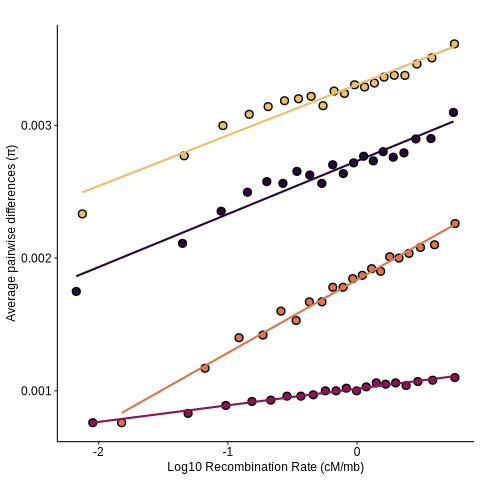

In [6]:
%%R
figure3a <- df %>%
    filter(species %in% c('Lemur_catta','Pongo_abelii','Macaca_fascicularis','Pithecia_albicans')) %>%
    ggplot(aes(x=log10(median_cm_mb),y=median_pi,col=species))+
    geom_point(aes(fill=species),color = 'black', size = 3, alpha = 1, shape = 21, stroke = 1)+
    geom_smooth(method='lm', se=FALSE)+
    scale_fill_manual(values = c('#db7552','#eabe6c','#891652', '#240a34'))+
    scale_colour_manual(values = c('#db7552','#eabe6c','#891652', '#240a34'))+
    labs(x = "Log10 Recombination Rate (cM/mb)", y = "Average pairwise differences (π)", title = "", size = 55) +
    ggpubr::theme_pubr(legend='none')
figure3a

#### B

In [7]:
%%R
a <- read_delim("../results/Full_model/hierarchical_model_a_250225.csv", delim=",")
b <- read_delim("../results/Full_model/hierarchical_model_b_250225.csv", delim=",")
h0 <- read_delim("../results/Full_model/hierarchical_model_h0_250225.csv", delim=",")
h1 <- read_delim("../results/Full_model/hierarchical_model_h1_250225.csv", delim =",")
Ne <- read_delim('../results/Ne_modelling/predicted_Ne.csv', delim = ',')


Rows: 1424000 Columns: 4
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (1): Species
dbl (3): chain, draw, a

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 1424000 Columns: 4
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (1): Species
dbl (3): chain, draw, b

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 8000 Columns: 3
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (3): chain, draw, h0

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 8000 Columns: 3
── Column specification ──────────────────────

In [8]:
%%R
# First, you need to get the standardization parameters used in your Python code
ne_mean <- mean(log10(Ne$Ne_median))
ne_std <- sd(log10(Ne$Ne_median))

# Define parameters
sample <- 1000
h0_vec <- sample(h0$h0, sample, replace = TRUE)
h1_vec <- sample(h1$h1, sample, replace = TRUE)

# Generate sampled points with proper standardization
sampled_points <- map_dfr(1:sample, ~{
  alpha <- sample(h0_vec, 1)
  beta <- sample(h1_vec, 1)
  
  # Create sequence of raw x values
  x_raw <- seq(2000, 5000000, by = 1000)
  x_log10 <- log10(x_raw)
  
  # Standardize x values the same way as in the model
  x_std <- (x_log10 - ne_mean) / ne_std
  
  # Apply model 
  y_std <- alpha + beta * x_std
  
  # Since your plot is showing raw b values, not re-scaling y
  tibble(x = x_raw, y = y_std, logx = x_log10)
})


sampled_points$x <- as.character(sampled_points$x)

HPDI_h1_ne <- sampled_points %>% 
    group_by(x,logx) %>%
    reframe(
        fifty_low = quantile(y,0.25),
        fifty_max = quantile(y,0.75),
        seventyfive_low = quantile(y,0.125),
        seventyfive_max = quantile(y,0.875),
        ninetyfive_low = quantile(y,0.025),
        ninetyfive_max = quantile(y,0.975)
        )
HPDI_h1_ne$x <- as.double(HPDI_h1_ne$x)
HPDI_h1_ne

# A tibble: 4,999 × 8
         x  logx fifty_low fifty_max seventyfive_low seventyfive_max
     <dbl> <dbl>     <dbl>     <dbl>           <dbl>           <dbl>
 1   10000  4      0.00454    0.0157       0.0000662          0.0196
 2 1001000  6.00   0.297      0.317        0.291              0.325 
 3 1002000  6.00   0.297      0.317        0.291              0.325 
 4 1003000  6.00   0.297      0.317        0.291              0.325 
 5 1004000  6.00   0.297      0.317        0.291              0.325 
 6 1005000  6.00   0.297      0.317        0.291              0.325 
 7 1006000  6.00   0.297      0.317        0.291              0.325 
 8 1007000  6.00   0.298      0.317        0.291              0.325 
 9 1008000  6.00   0.298      0.317        0.291              0.325 
10 1009000  6.00   0.298      0.317        0.291              0.325 
# ℹ 4,989 more rows
# ℹ 2 more variables: ninetyfive_low <dbl>, ninetyfive_max <dbl>
# ℹ Use `print(n = ...)` to see more rows


In [9]:
%%R
b_species <- b %>% 
    group_by(Species) %>% reframe(
    upper = quantile(b,.95),
    lower = quantile(b,.05),
    b = mean(b))
b_species

# A tibble: 178 × 4
   Species                      upper   lower      b
   <chr>                        <dbl>   <dbl>  <dbl>
 1 Allenopithecus_nigroviridis 0.0980 0.0774  0.0877
 2 Allochrocebus_lhoesti       0.0735 0.0528  0.0631
 3 Allochrocebus_preussi       0.103  0.0828  0.0930
 4 Allochrocebus_solatus       0.0932 0.0714  0.0822
 5 Alouatta_belzebul           0.113  0.0910  0.102 
 6 Alouatta_caraya             0.0296 0.00764 0.0186
 7 Alouatta_discolor           0.120  0.0979  0.109 
 8 Alouatta_juara              0.0997 0.0782  0.0889
 9 Alouatta_macconnelli        0.136  0.114   0.125 
10 Alouatta_nigerrima          0.156  0.134   0.145 
# ℹ 168 more rows
# ℹ Use `print(n = ...)` to see more rows


In [10]:
%%R
df_b_ne <- Ne %>%
  left_join(b_species, by = c("species" = "Species"))

In [11]:
%%R
# Fix the posterior_predictive function to properly standardize the x values
posterior_predictive <- function(x, slope_samples, intercept_samples, ne_mean, ne_std) {
  # Standardize x the same way as in your model
  x_std <- (x - ne_mean) / ne_std
  # Apply model parameters to standardized x
  intercept_samples + slope_samples * x_std
}

# Fix the credibility_interval function
credibility_interval <- function(x, slope_samples, intercept_samples, ne_mean, ne_std, prob = c(0.025, 0.975)) {
  quantile(posterior_predictive(x, slope_samples, intercept_samples, ne_mean, ne_std), prob)
}

# Calculate the credibility intervals with proper standardization
x_values <- c()
lower_bounds <- c()
upper_bounds <- c()

# Calculate the credibility intervals for each x value
for (i in log10(df_b_ne$Ne_median)) {
  cred_int <- credibility_interval(i, h1$h1, h0$h0, ne_mean, ne_std)
  x_values <- c(x_values, i)
  lower_bounds <- c(lower_bounds, cred_int[1])
  upper_bounds <- c(upper_bounds, cred_int[2])
}

# Create a data frame for plotting
mean_reg_line <- data.frame(
  x = x_values,
  lower_bound = lower_bounds,
  upper_bound = upper_bounds
)

In [12]:
%%R
names <- read_delim('../data/genus_phylogenetic_group_metadata.txt', delim = '\t')

df_b_ne <- df_b_ne %>% mutate(species_ssp = species)
df_b_ne <- df_b_ne %>% separate(species, c('genus', 'ssp'))
df_b_ne <- merge(df_b_ne, names ,by="genus")
df_b_ne
 

Rows: 57 Columns: 2
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (2): genus, pg_name

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
             genus              ssp median_predicted_rate  Ne_median   Ne_upper
1   Allenopithecus     nigroviridis          8.377808e-09  46501.822  53238.531
2    Allochrocebus          lhoesti          8.377808e-09  76989.113  88142.509
3    Allochrocebus          preussi          8.377808e-09  95639.576 109494.861
4    Allochrocebus          solatus          8.377808e-09 115782.077 132555.401
5         Alouatta         belzebul          8.871836e-09  49595.148  56742.766
6         Alouatta           caraya          8.871836e-09  20570.715  23535.352
7         Alouatta         discolor          8.871836e-09  62698.411  71734.462
8         Alouatta            juara          8.635916e-09  59634

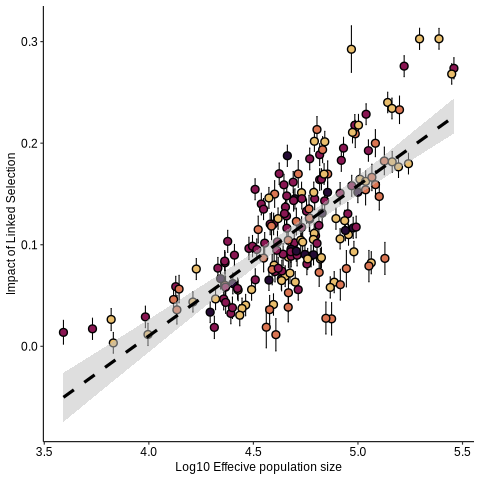

In [13]:
%%R
fig3_par1 <- df_b_ne %>% 
    ggplot()+
    geom_errorbar(aes(x = log10(Ne_median), ymin=lower, ymax=upper), col = 'black', width=.005,
                     position=position_dodge(.9)) +
    geom_point(aes(x=log10(Ne_median),y=b, fill=pg_name), color = 'black', size = 3, alpha = 1, shape = 21, stroke = 1)+
    geom_ribbon(data=mean_reg_line, aes(x= x, ymin = lower_bound, ymax = upper_bound), fill='grey', alpha = .5)+
    geom_line(aes(x = log10(Ne_median), 
               y = mean(h0$h0) + mean(h1$h1) * ((log10(Ne_median) - ne_mean) / ne_std)),
          lty = 2, size = 1.5)+
    scale_fill_manual(values=c('#240a34','#891652','#eabe6c','#db7552')) +
     ylab("Impact of Linked Selection")+
     xlab('Log10 Effecive population size')+
    ggpubr::theme_pubr(legend = 'none')
print(fig3_par1)

In [ ]:
%%R
ggsave("../figures/figure3/figure3b.png", 
    fig3_par1, 
    width = 15,    # Width in inches
    height = 8,    # Height in inches
    dpi = 600)  

#### Combine

`geom_smooth()` using formula = 'y ~ x'


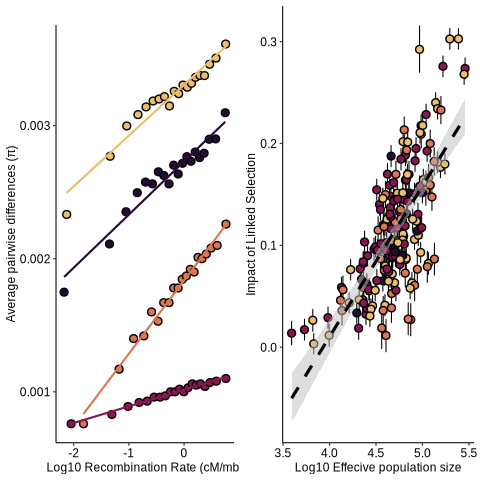

In [15]:
%%R
fig3 <- ggarrange(figure3a,fig3_par1, ncol = 2 )
print(fig3)
ggsave("../figures/figure3/figure3_combined.png", fig3, width = 15, height = 6, dpi = 600)

### Quantifications

In [14]:
%%R
# Using your h0 and h1 samples from the model
# Calculate effect of doubling population size on linked selection

# When population size doubles, log10(Ne) increases by log10(2) ≈ 0.301
log10_factor <- log10(2)

# Calculate the standardized change in Ne
delta_z_ne <- log10_factor / ne_std

# Calculate the effect for each posterior sample
effects <- h1$h1 * delta_z_ne

# Calculate mean effect and HDPIs
mean_effect <- mean(effects)
hdpi_95 <- quantile(effects, probs = c(0.025, 0.975))

# Print the results
cat("When effective population size (Ne) doubles:\n")
cat(sprintf("- The impact of linked selection increases by %.3f\n", mean_effect))
cat(sprintf("- 95%% HDPI: [%.3f, %.3f]\n", hdpi_95[1], hdpi_95[2]))

# Calculate relative increase for a species with average linked selection
avg_linked_selection <- mean(df_b_ne$b)
cat(sprintf("\nFor a species with average linked selection impact of %.3f:\n", avg_linked_selection))
cat(sprintf("- Doubling Ne increases linked selection to %.3f\n", avg_linked_selection + mean_effect))
cat(sprintf("- This represents a %.1f%% increase\n", (mean_effect/avg_linked_selection) * 100))

# Calculate for specific quantiles of linked selection
quantiles <- quantile(df_b_ne$b, probs = c(0.25, 0.5, 0.75))
cat("\nEffect at different baseline linked selection values:\n")
for (q in names(quantiles)) {
  base <- quantiles[[q]]
  cat(sprintf("%s quantile (%.3f): increases to %.3f (%.1f%% increase)\n", 
              q, base, base + mean_effect, (mean_effect/base) * 100))
}

When effective population size (Ne) doubles:
- The impact of linked selection increases by 0.045
- 95% HDPI: [0.038, 0.051]

For a species with average linked selection impact of 0.115:
- Doubling Ne increases linked selection to 0.159
- This represents a 38.8% increase

Effect at different baseline linked selection values:
25% quantile (0.067): increases to 0.112 (66.3% increase)
50% quantile (0.104): increases to 0.149 (42.7% increase)
75% quantile (0.152): increases to 0.196 (29.4% increase)


In [16]:
%%R
# 1. Predict linked selection impact across Ne range
predict_linked_selection <- function(log10_ne, h0_samples, h1_samples, ne_mean, ne_std) {
  # Standardize Ne
  ne_std_value <- (log10_ne - ne_mean) / ne_std
  
  # Calculate for each posterior sample
  predictions <- h0_samples + h1_samples * ne_std_value
  
  # Return as a named list
  list(
    mean = mean(predictions),
    lower = quantile(predictions, 0.025),
    upper = quantile(predictions, 0.975)
  )
}

# Calculate for a range of Ne values
ne_range <- seq(from = 3.5, to = 5.5, by = 0.5)
predicted_values <- lapply(ne_range, predict_linked_selection, 
                           h0_samples = h0$h0, 
                           h1_samples = h1$h1, 
                           ne_mean = ne_mean, 
                           ne_std = ne_std)

# Make it into a nice table
pred_table <- data.frame(
  log10_Ne = ne_range,
  Ne = 10^ne_range,
  mean = sapply(predicted_values, function(x) x$mean),
  lower = sapply(predicted_values, function(x) x$lower),
  upper = sapply(predicted_values, function(x) x$upper)
)

print("Predicted linked selection impact across Ne range:")
print(pred_table)

[1] "Predicted linked selection impact across Ne range:"
  log10_Ne         Ne        mean        lower       upper
1      3.5   3162.278 -0.06375707 -0.089843748 -0.03781305
2      4.0  10000.000  0.01026613 -0.005757403  0.02670662
3      4.5  31622.777  0.08428933  0.076715304  0.09236645
4      5.0 100000.000  0.15831253  0.149247014  0.16767741
5      5.5 316227.766  0.23233573  0.214879464  0.25102095


In [17]:
%%R
# 2. Calculate Ne thresholds for specific linked selection impacts
calculate_ne_threshold <- function(threshold, h0_samples, h1_samples, ne_mean, ne_std) {
  # For each posterior sample, calculate required Ne in standardized scale
  required_ne_std <- (threshold - h0_samples) / h1_samples
  
  # Filter out invalid values (e.g., when h1 ≈ 0)
  valid_values <- required_ne_std[is.finite(required_ne_std)]
  
  # Convert from standardized to raw scale
  required_log10_ne <- (valid_values * ne_std) + ne_mean
  required_ne <- 10^required_log10_ne
  
  # Return as a named list
  list(
    median = median(required_ne),
    q025 = quantile(required_ne, 0.025),
    q975 = quantile(required_ne, 0.975)
  )
}

# Calculate for several thresholds
thresholds <- c(0.05, 0.10, 0.15, 0.20, 0.25)
ne_thresholds <- lapply(thresholds, calculate_ne_threshold,
                        h0_samples = h0$h0,
                        h1_samples = h1$h1,
                        ne_mean = ne_mean,
                        ne_std = ne_std)

threshold_table <- data.frame(
  impact = thresholds,
  median_ne = sapply(ne_thresholds, function(x) x$median),
  lower_ne = sapply(ne_thresholds, function(x) x$q025),
  upper_ne = sapply(ne_thresholds, function(x) x$q975)
)

print("\nNe thresholds for specific linked selection impacts:")
print(threshold_table)

[1] "\nNe thresholds for specific linked selection impacts:"
  impact median_ne  lower_ne  upper_ne
1   0.05  18555.01  15101.43  21598.66
2   0.10  40420.61  35932.56  44603.77
3   0.15  87910.25  77712.93 101318.03
4   0.20 191675.93 157007.06 242606.80
5   0.25 416813.56 311690.60 595806.49


In [18]:
%%R
# For the Bayesian R-squared, use a more direct approach with your fitted values
# Assuming df_b_ne has your observed values

# Calculate predicted values for each observation
predicted_vals <- numeric(nrow(df_b_ne))
for (i in 1:nrow(df_b_ne)) {
  log10_ne_i <- log10(df_b_ne$Ne_median[i])
  z_ne_i <- (log10_ne_i - ne_mean) / ne_std
  predicted_vals[i] <- mean(h0$h0) + mean(h1$h1) * z_ne_i
}

# Calculate correlation
r_val <- cor(predicted_vals, df_b_ne$b)
r_squared <- r_val^2

cat("\nProportion of variance in linked selection explained by Ne:", 
    sprintf("%.1f%%", r_squared * 100))


Proportion of variance in linked selection explained by Ne: 52.1%

# Quantifications

In [ ]:
#basic dataset quantifcations 
df = pd.read_csv('../results/stats/all_species_ne.combined.stats.filtered.csv', sep=',')

,Unnamed: 0,chrom,start,end,n_variants,diversity,n_singletons,singleton_proportion,tajima_d,bases,...,freq_median,window_size_mean,sum_n_mean,species,genus,phylogenetic_group,median_predicted_rate,Ne_median,Ne_upper,Ne_lower
0,0,chr1,1600001,1700000,265.0,0.000543,155.0,0.584906,-1.398232,100000.0,...,0.511440,99999.0,50647.125000,Cheracebus_lugens,Cheracebus,New_world_monkeys,7.769189e-09,43851.101463,51099.766771,37691.201743
1,1,chr1,1800001,1900000,200.0,0.000439,89.0,0.445000,-1.180108,100000.0,...,0.624306,99999.0,61995.750000,Cheracebus_lugens,Cheracebus,New_world_monkeys,7.769189e-09,43851.101463,51099.766771,37691.201743
2,2,chr1,1900001,2000000,332.0,0.000877,108.0,0.325301,-0.539073,100000.0,...,0.556926,99999.0,55266.250000,Cheracebus_lugens,Cheracebus,New_world_monkeys,7.769189e-09,43851.101463,51099.766771,37691.201743
3,3,chr1,2000001,2100000,292.0,0.000708,131.0,0.448630,-0.855039,100000.0,...,0.543250,99999.0,53921.125000,Cheracebus_lugens,Cheracebus,New_world_monkeys,7.769189e-09,43851.101463,51099.766771,37691.201743
4,4,chr1,2200001,2300000,267.0,0.000631,119.0,0.445693,-0.939903,100000.0,...,0.697112,99999.0,69178.500000,Cheracebus_lugens,Cheracebus,New_world_monkeys,7.769189e-09,43851.101463,51099.766771,37691.201743
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3818186,3818186,chr9,134800001,134900000,510.0,0.001070,226.0,0.443137,-0.964267,100000.0,...,0.530415,99999.0,49476.000000,Pan_paniscus,Pan,Great_apes,1.071039e-08,22035.798423,25789.453144,19372.684874
3818187,3818187,chr9,134900001,135000000,380.0,0.000736,180.0,0.473684,-1.206037,100000.0,...,0.612326,99999.0,57539.692308,Pan_paniscus,Pan,Great_apes,1.071039e-08,22035.798423,25789.453144,19372.684874
3818188,3818188,chr9,135000001,135100000,477.0,0.001095,180.0,0.377358,-0.668335,100000.0,...,0.607536,99999.0,57009.307692,Pan_paniscus,Pan,Great_apes,1.071039e-08,22035.798423,25789.453144,19372.684874
3818189,3818189,chr9,135400001,135500000,524.0,0.001161,176.0,0.335878,-0.790234,100000.0,...,0.598636,99999.0,55502.769231,Pan_paniscus,Pan,Great_apes,1.071039e-08,22035.798423,25789.453144,19372.684874


In [9]:
# Number of species retained 
len(df['species'].unique())

178

In [15]:
# Number of windows per species
df.groupby('species').count()['chrom'].median()

23547.5

In [20]:
# average total snp count per species
df.groupby('species')['n_variants'].sum().median()

4766454.5

In [22]:
# Genome average diversity per species 
df.groupby('species')['diversity'].median().sort_values()

species
Alouatta_palliata               0.000130
Mico_spnv                       0.000140
Rhinopithecus_bieti             0.000190
Trachypithecus_leucocephalus    0.000250
Leontopithecus_rosalia          0.000262
                                  ...   
Aotus_vociferans                0.004611
Cercopithecus_ascanius          0.005862
Cercopithecus_cephus            0.006324
Semnopithecus_entellus          0.008558
Chiropotes_albinasus            0.008817
Name: diversity, Length: 178, dtype: float64

In [ ]:
# Ne in each species 
df.groupby('species')['Ne_median'].median().sort_values()

species
Alouatta_palliata                 3904.873960
Mico_spnv                         5376.536661
Rhinopithecus_bieti               6603.924718
Trachypithecus_leucocephalus      6762.974675
Leontopithecus_rosalia            9627.231353
                                    ...      
Mandrillus_sphinx               174406.875750
Cercopithecus_ascanius          197026.989128
Cercopithecus_cephus            244083.817008
Semnopithecus_entellus          280763.665807
Chiropotes_albinasus            287675.404565
Name: Ne_median, Length: 178, dtype: float64

In [24]:
# Relative reduction quantifications 
rr = pd.read_csv('../results/stats/relative_reduction_data.csv', sep=',')

In [ ]:
# relative reduction across all species
rr.groupby('species')['relative_pi_difference'].median().sort_values()

species
Alouatta_palliata              -0.076923
Trachypithecus_leucocephalus    0.000000
Otolemur_crassicaudatus         0.157447
Semnopithecus_entellus          0.185583
Chiropotes_albinasus            0.190475
                                  ...   
Microcebus_murinus              0.613982
Macaca_assamensis               0.616923
Mandrillus_leucophaeus          0.655894
Lemur_catta                     0.663717
Aotus_trivirgatus               0.790698
Name: relative_pi_difference, Length: 178, dtype: float64

In [ ]:
# median relative reduction 
rr['relative_pi_difference'].median()

0.40338993871296575